# Inicialización

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')  # allow importing from parent directory
from fun_gilles import *
import pickle
import pandas as pd

In [2]:
colors = plt.get_cmap('Set2').colors

In [3]:
def plot_barrido(c_inicial, c_equilibrio, species):

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,8), sharex=True)
    
    n_conditions = np.arange(len(c_inicial))
    
    # --- Subplot 1: condiciones iniciales ---
    ax1 = axes[0]
    for i in range(len(species)):
        ax1.plot(n_conditions, c_inicial[:, i], label=species[i], color=colors[i], alpha=0.9, marker= "s")
    ax1.grid(True, linestyle='--', alpha=0.3)
    ax1.set_xlabel("Simulation")
    ax1.set_ylabel("Initial concentration")
    ax1.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), title="Species")
    
    ax2 = axes[1]
    for i in range(len(species)):
        ax2.plot(n_conditions, c_equilibrio[:, i], label=species[i], color=colors[i], alpha=0.9, marker= "s")
    ax2.grid(True, linestyle='--', alpha=0.3)
    ax2.set_xlabel("Simulation")
    ax2.set_ylabel("Equilibrium concentration")    

In [4]:
def plot_volume(v_f,ab_initial):
    
    # --- Plot ---
    plt.plot(ab_initial, v_f, color= "slategray", marker= "s")
    plt.xlabel("Initial [ab]")
    plt.ylabel("Volume at t = 10")


In [5]:
def plot(abundances, times, V, species):

    # --- Create the figure and a 1-row, 3-column subplot grid ---
    # Using a wide figsize for a horizontal layout.
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True) 
    # Note: sharex=True is removed because we need the x-axis ticks on all three plots, 
    # although they are the same (time).

    # --- Subplot 1 (Left): Concentration ---
    ax1 = axes[0]
    for i in range(len(species)):
        # Calculate Concentration = Abundance / Volume
        ax1.plot(times, abundances[:, i] / V, label=species[i], color=colors[i], alpha=0.9)
    ax1.grid(True, linestyle='--', alpha=0.3)
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Concentration")
    ax1.set_title("Concentration Evolution")
    ax1.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), title="Species")


    # --- Subplot 2 (Middle): Volume ---
    ax2 = axes[1]
    ax2.plot(times, V, color='gray')
    ax2.grid(True, linestyle='--', alpha=0.3)
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Volume")
    # ax2.set_yscale("log")
    ax2.set_title("Volume Evolution")


   
    # Adjust layout to prevent labels/titles from overlapping
    plt.tight_layout(rect=[0, 0, 1, 1]) # Adjust tight_layout for a single row

    plt.show()

In [6]:
def plot_volume_vs_k(v_f,k_i,k, i):
    
    # --- Plot ---
    plt.plot(k_i/k[i+1], v_f, color= "slategray", marker= "s")
    plt.xlabel(fr"$K_{round(i/2)+1}$")
    plt.ylabel("Volume at t = 10")
    plt.xscale("log")

In [7]:
f = '../examples/reactions_autocat.txt'
reactions = read_file(f)
species = obtain_species(reactions)

In [8]:
def load_streamed_pickle(filename):
    data = {}
    try:
        with open(filename, "rb") as file:
            while True:
                try:
                    # Load one object (which is a dict of {k_i: (abundances, times, volumes)})
                    chunk = pickle.load(file)
                    # Merge the loaded chunk into the main dictionary
                    data.update(chunk)
                except EOFError:
                    # Reached the end of the file
                    break
    except FileNotFoundError:
        print(f"Error: File '{filename}' not found.")
    
    print(f"Successfully loaded {len(data)} simulation results.")
    return data

# barrido

In [9]:
with open("../barrido_ab.txt", "rb") as file:
    barrido_ab = pickle.load(file)

with open("../barrido_k0.txt", "rb") as file:
    barrido_k0 = pickle.load(file)
    
with open("../barrido_k2.txt", "rb") as file:
    barrido_k2 = pickle.load(file)

In [10]:
filename = "../barrido_k0_stream.pkl"
barrido_k0.update(load_streamed_pickle(filename))
barrido_k2.update(load_streamed_pickle(filename="../barrido_k2_stream.pkl"))

Successfully loaded 5 simulation results.
Successfully loaded 7 simulation results.


## ajuste a log (funciones)

In [9]:
from numpy.polynomial.polynomial import polyfit

def get_alpha(volumes, times):
    # 1. Transform the data
    log_v = np.log(volumes)
    
    # 2. Perform linear regression: log(V) = log(A) + m * t
    coefficients = polyfit(times, log_v, 1)
    
    # Extract the intercept (log(A)) and slope (m)
    log_A_fit = coefficients[0]
    m_fit = coefficients[1] 
    
    # 3. Calculate the scaling constant A
    A_fit = np.exp(log_A_fit)
    
    
    # --- R-SQUARED CALCULATION ---
    
    # a) Calculate the predicted log(V) values
    # log(V)_predicted = log(A)_fit + m_fit * t
    log_v_predicted = log_A_fit + m_fit * times
    
    # b) Calculate the Mean of the actual log(V) data
    log_v_mean = np.mean(log_v)
    
    # c) Calculate Sum of Squares of Residuals (SS_res)
    # The sum of the squared differences between actual y and predicted y
    SS_res = np.sum((log_v - log_v_predicted)**2)
    
    # d) Calculate Total Sum of Squares (SS_tot)
    # The sum of the squared differences between actual y and mean y
    SS_tot = np.sum((log_v - log_v_mean)**2)
    
    # e) Calculate R-squared
    R_squared = 1 - (SS_res / SS_tot)
    
    # -----------------------------
    
    print(f"Regression completed. Fitted Scaling Constant A: {A_fit:.3f}")
    print(f"Fitted exponential rate m (alpha): {m_fit:.3f}")
    print(f"Coefficient of Determination (R^2): {R_squared:.4f}")
    
    def function_v(t_new):
        if t_new < 0:
            raise ValueError("Time cannot be negative")
        
        # *** CRITICAL CORRECTION HERE: USE EXPONENTIAL FUNCTION ***
        predicted_V = A_fit * np.exp(m_fit * t_new) 
        # V(t) = A * e^(m * t)
        return predicted_V

    return function_v


In [10]:
def plot_ajuste(abundances, times, volumes, species):


        # --- Create the figure and a 1-row, 3-column subplot grid ---
        # Using a wide figsize for a horizontal layout.
        fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True) 
        # Note: sharex=True is removed because we need the x-axis ticks on all three plots, 
        # although they are the same (time).

        # --- Subplot 1 (Left): Concentration ---
        ax1 = axes[0]
        for i in range(len(species)):
        # Calculate Concentration = Abundance / Volume
                ax1.plot(times, abundances[:, i] / volumes, label=species[i], color=colors[i], alpha=0.9)
        ax1.grid(True, linestyle='--', alpha=0.3)
        ax1.set_xlabel("Time")
        ax1.set_ylabel("Concentration")
        ax1.set_title("Concentration Evolution")
        ax1.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), title="Species")


        # --- Subplot 2 (Middle): Volume ---
        ax2 = axes[1]
        ax2.plot(times, volumes, color='gray')
        ax2.grid(True, linestyle='--', alpha=0.3)
        ax2.set_xlabel("Time")
        ax2.set_ylabel("Volume")
        # ax2.set_yscale("log")
        ax2.set_title("Volume Evolution and Fit")


        # --- Final Touches ---
        # Add a figure-wide title
        fig.suptitle(
                fr"Simulation Results ($K_1$ = {round(k[1]/k[0])}, $K_2$ = {round(k[3]/k[2])}, $K_3$ = {round(k[5]/k[4])}, $K_4$ = {round(k[7]/k[6])})")


        func = get_alpha(volumes[round(len(times)/5):], times[round(len(times)/5):])

        volume_predicted = []

        for t in times[round(len(times)/5):]:
                volume_predicted.append(func(t))

        volume_predicted = np.array(volume_predicted)

        ax2.plot(times[round(len(times)/5):], volume_predicted, 
                label=fr'Fit'
        )
        ax2.legend(loc='lower right')


        plt.tight_layout()
        plt.show()
        print("Plot generated successfully.")

In [11]:
def get_alpha_global(results: dict):
    # Initialize a list of lists/tuples to hold the data temporarily
    data = [] 
    
    for conc, (species, times, volumes) in results.items(): 
        
        times = np.array(times)
        volumes = np.array(volumes)
        
            
        # Use data points from index len(x)/2 onwards for a better fit
        log_v = np.log(volumes[round(len(volumes)/5):])
        t_subset = times[round(len(times)/5):]
        
        # 2. Perform linear regression
        coefficients = polyfit(t_subset, log_v, 1)
        log_A_fit = coefficients[0]
        m_fit = coefficients[1] # alpha
        A_fit = np.exp(log_A_fit)
        
        # --- R-SQUARED CALCULATION (Use the same logic as before, but with subsets) ---
        log_v_predicted = log_A_fit + m_fit * t_subset
        log_v_mean = np.mean(log_v)
        SS_res = np.sum((log_v - log_v_predicted)**2)
        SS_tot = np.sum((log_v - log_v_mean)**2)
        R_squared = 1 - (SS_res / SS_tot)
        
        # Append the calculated metrics to the data list
        data.append({
            'Condition': conc,
            'Alpha': m_fit,
            'Scaling Const. (A)': A_fit,
            'R^2': R_squared
        })
    
    # Convert the list of dictionaries into a DataFrame
    df_fit = pd.DataFrame(data)
    df_fit = df_fit.sort_values(by=['Condition'])
    return df_fit

In [12]:
def get_alpha_single_run(cond:float, result:tuple):
    _, times, volumes = result
        
    times = np.array(times)
    volumes = np.array(volumes)
    
    # Use data points from index len/5 onwards
    start_idx = round(len(volumes) / 5)
    log_v = np.log(volumes[start_idx:])
    t_subset = times[start_idx:]
    
    # 2. Perform linear regression
    # polyfit(x, y, 1) returns [slope, intercept]
    coefficients = np.polyfit(t_subset, log_v, 1)
    m_fit = coefficients[0]      # This is alpha (slope)
    log_A_fit = coefficients[1]  # This is the intercept
    A_fit = np.exp(log_A_fit)
    
    # --- R-SQUARED CALCULATION ---
    log_v_predicted = log_A_fit + m_fit * t_subset
    log_v_mean = np.mean(log_v)
    SS_res = np.sum((log_v - log_v_predicted)**2)
    SS_tot = np.sum((log_v - log_v_mean)**2)
    R_squared = 1 - (SS_res / SS_tot) if SS_tot != 0 else 0
    
    # Return a dictionary directly
    return {
        'Condition': cond,
        'Alpha': m_fit,
        'Scaling Const. (A)': A_fit,
        'R^2': R_squared
    }

## ajuste AB

In [15]:
fit = get_alpha_global(barrido_ab)

(0.0, 1.0)

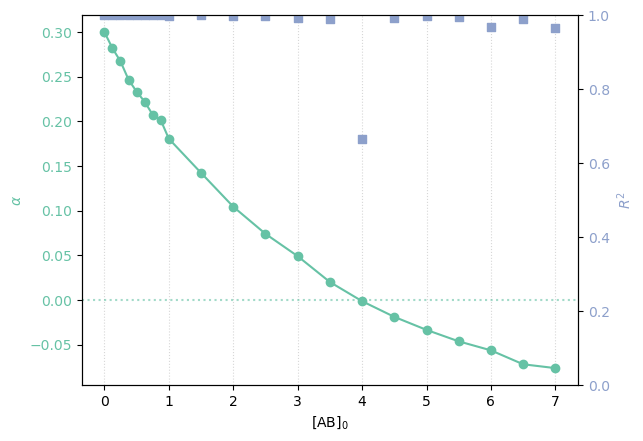

In [16]:
fig, ax1 = plt.subplots()

ax1.set_xlabel(r'$[\text{AB}]_0$') 
ax1.set_ylabel(r'$\alpha$', color=colors[0])
ax1.plot(fit['Condition'], fit['Alpha'], 
            color=colors[0], marker='o')

ax1.tick_params(axis='y', labelcolor=colors[0])
ax1.grid(True, linestyle=':', alpha=0.5, which='both', axis='x')
ax1.axhline(y= 0, color= colors[0], alpha= 0.6, linestyle=":")

ax2 = ax1.twinx()  

ax2.set_ylabel(r'$R^2$', color=colors[2])  
ax2.scatter(fit['Condition'], fit['R^2'], 
            color=colors[2], marker='s')
ax2.tick_params(axis='y', labelcolor=colors[2])
ax2.set_ylim((0,1.0))


In [17]:
barrido_ab.keys()

dict_keys([0.001, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0])

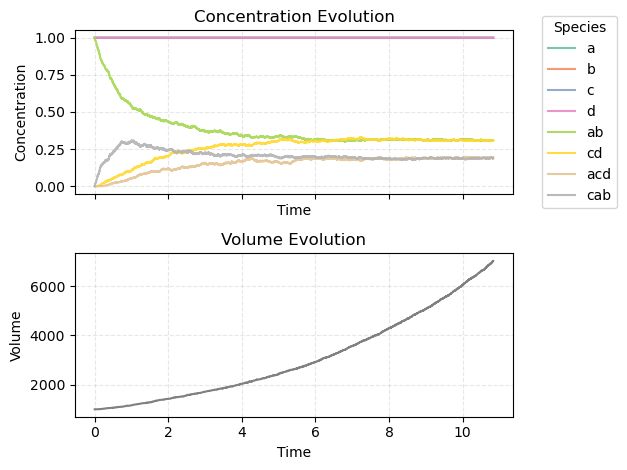

In [18]:
abundances, times, volumes = barrido_ab[1]
plot(abundances, times, volumes, species)

In [21]:
abundances.shape

(52002, 8)

In [ ]:
# abundances, times, volumes = chemistry(method= "Gillespie",
#                                        iterations= 2e5,
#                                        file="../examples/reactions_autocat.txt",
#                                        initial_food=[0]*4 + [1000] + [0]*3,
#                                        k= [1]*8+[0.2]*4,
#                                        V=1000,
#                                        threshold= 0.)

KeyboardInterrupt: 

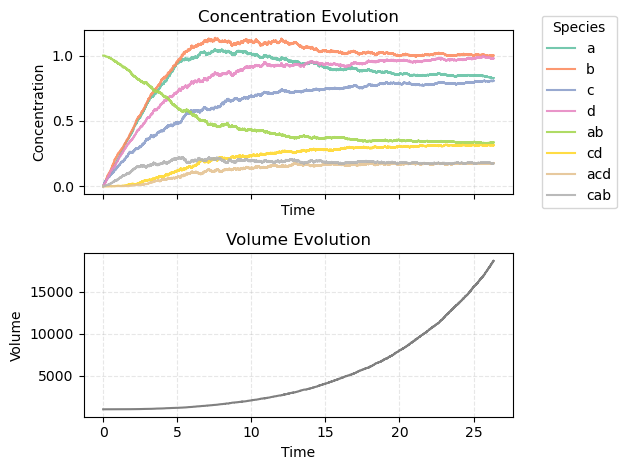

In [ ]:
plot(abundances, times, volumes, species)

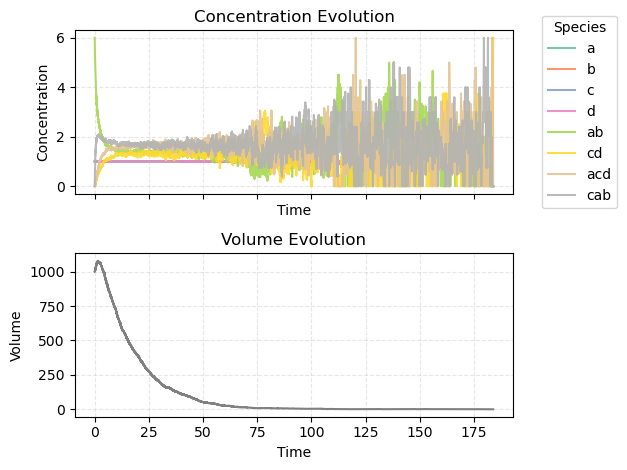

In [ ]:
abundances, times, volumes = barrido_ab[6]
plot(abundances, times, volumes, species)

In [ ]:
# abundances, times, volumes = chemistry(method= "Gillespie",
#                                        iterations= 2e5,
#                                        file="../examples/reactions_autocat.txt",
#                                        initial_food=[0]*4 + [6000] + [0]*3,
#                                        k= [1]*8+[0.2]*4,
#                                        V=1000,
#                                        threshold= 0.)

Criterion for stop was # of iterations


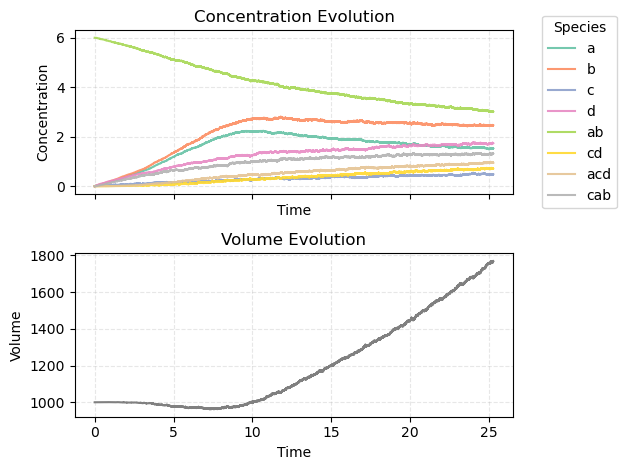

In [ ]:
plot(abundances, times, volumes, species)

### con k_0 = 1e2

Successfully loaded 17 simulation results.


(0.0, 1.0)

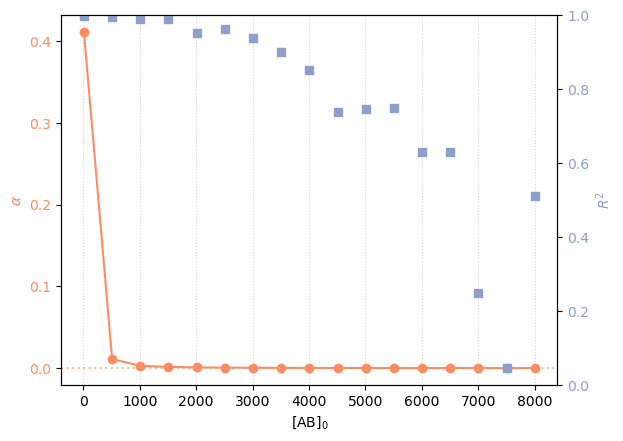

In [ ]:
barrido_ab_k0_e2 = load_streamed_pickle("../barrido_ab0_k0_e2.pkl")

fit = get_alpha_global(barrido_ab_k0_e2)

fig, ax1 = plt.subplots()

ax1.set_xlabel(r'$[\text{AB}]_0$') 
ax1.set_ylabel(r'$\alpha$', color=colors[1])
ax1.plot(fit['Condition'], fit['Alpha'], 
            color=colors[1], marker='o')

ax1.tick_params(axis='y', labelcolor=colors[1])
ax1.grid(True, linestyle=':', alpha=0.5, which='both', axis='x')
ax1.axhline(y= 0, color= colors[1], alpha= 0.6, linestyle=":")

ax2 = ax1.twinx()  

ax2.set_ylabel(r'$R^2$', color=colors[2])  
ax2.scatter(fit['Condition'], fit['R^2'], 
            color=colors[2], marker='s')
ax2.tick_params(axis='y', labelcolor=colors[2])
ax2.set_ylim((0,1.0))

Regression completed. Fitted Scaling Constant A: 1000.000
Fitted exponential rate m (alpha): 0.000
Coefficient of Determination (R^2): 0.5108


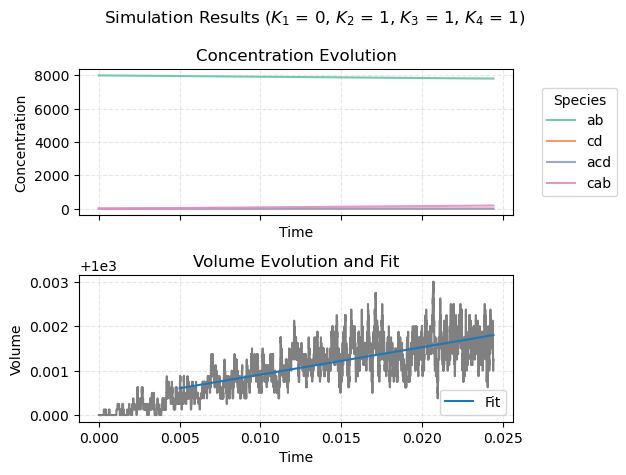

Plot generated successfully.


1000.0

In [ ]:
ab0 = 8002.0
k = [1]*8
k[0] = 1e2
abundances, times, volumes = barrido_ab_k0_e2[ab0]
plot_ajuste(abundances[:,4:], times, volumes, species[4:])
volumes[0]

In [ ]:
ab0 = 8002.0
k = [1]*8
k[0] = 1e2
# less resolution
v0 = 100
initial_food = [100]*4 + [ab0*v0] + [0]*3

abundances, times, volumes = chemistry(method='Protocell', iterations=2e5, 
                                       file= f, initial_food= initial_food, k= k, V= v0,
                                       threshold= threshold_function(v0, margin= 10))

KeyboardInterrupt: 

Regression completed. Fitted Scaling Constant A: 100.023
Fitted exponential rate m (alpha): -0.003
Coefficient of Determination (R^2): 0.9126


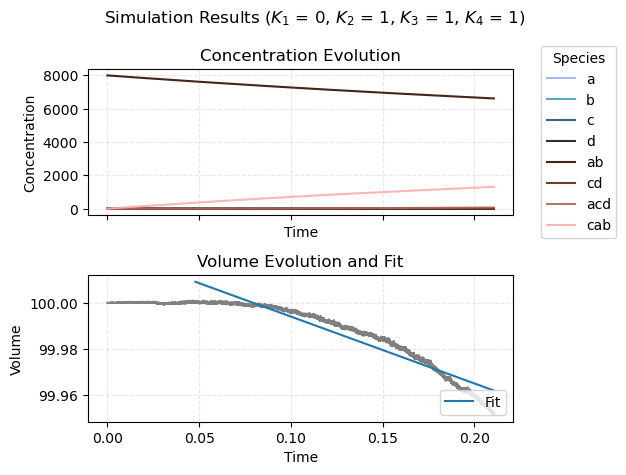

Plot generated successfully.


In [ ]:
plot_ajuste(abundances, times, volumes, species)

In [ ]:
k= [1]*8
print(barrido_ab.keys())
for i in barrido_ab.keys():
    if i == 0.5 or i == 4 or i == 6:
        abundances, times, volumes = barrido_ab[i]
        plot_ajuste(abundances, times, volumes, species)

### con k_1 variando

Successfully loaded 23 simulation results.


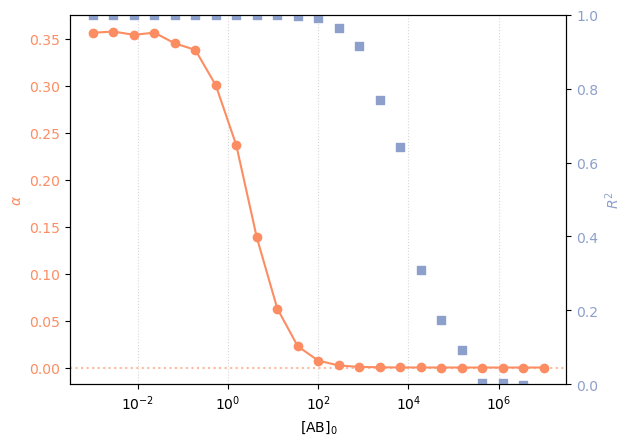

In [ ]:
barrido_ab_k1_em4 = load_streamed_pickle("../barrido_ab0_k1_0.0001.pkl")

fit = get_alpha_global(barrido_ab_k1_em4)

fig, ax1 = plt.subplots()

ax1.set_xlabel(r'$[\text{AB}]_0$') 
ax1.set_ylabel(r'$\alpha$', color=colors[1])
ax1.plot(fit['Condition'], fit['Alpha'], 
            color=colors[1], marker='o')

ax1.tick_params(axis='y', labelcolor=colors[1])
ax1.grid(True, linestyle=':', alpha=0.5, which='both', axis='x')
ax1.axhline(y= 0, color= colors[1], alpha= 0.6, linestyle=":")
ax1.set_xscale('log')

ax2 = ax1.twinx()  

ax2.set_ylabel(r'$R^2$', color=colors[2])  
ax2.scatter(fit['Condition'], fit['R^2'], 
            color=colors[2], marker='s')
ax2.tick_params(axis='y', labelcolor=colors[2])
ax2.set_ylim((0,1.0))
ax2.set_xscale('log')


In [ ]:
barrido_ab_k1_em4.keys()

dict_keys([0.001, 0.002848035868435802, 0.008111308307896872, 0.02310129700083159, 0.0657933224657568, 0.1873817422860383, 0.5336699231206307, 1.5199110829529332, 4.328761281083057, 12.32846739442066, 35.11191734215127, 100.0, 284.8035868435799, 811.1308307896873, 2310.1297000831582, 6579.332246575683, 18738.17422860383, 53366.99231206302, 151991.10829529332, 432876.12810830615, 1232846.7394420635, 3511191.7342151273, 10000000.0])

Regression completed. Fitted Scaling Constant A: 1000.000
Fitted exponential rate m (alpha): 0.000
Coefficient of Determination (R^2): 0.6421


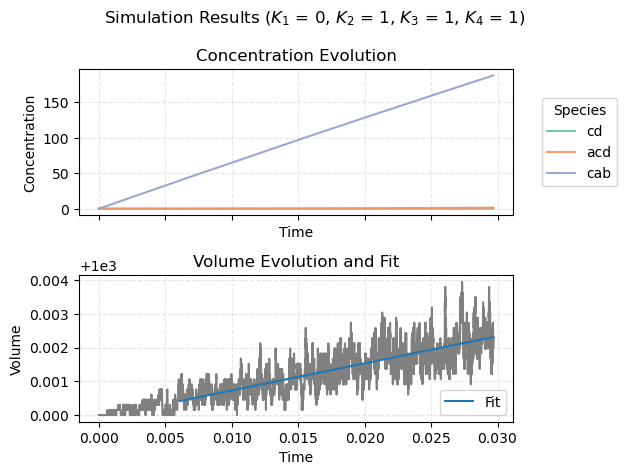

Plot generated successfully.


In [ ]:
abundances, times, volumes = barrido_ab_k1_em4[6579.332246575683]
plot_ajuste(abundances[:,5:], times, volumes, species[5:])

Successfully loaded 23 simulation results.


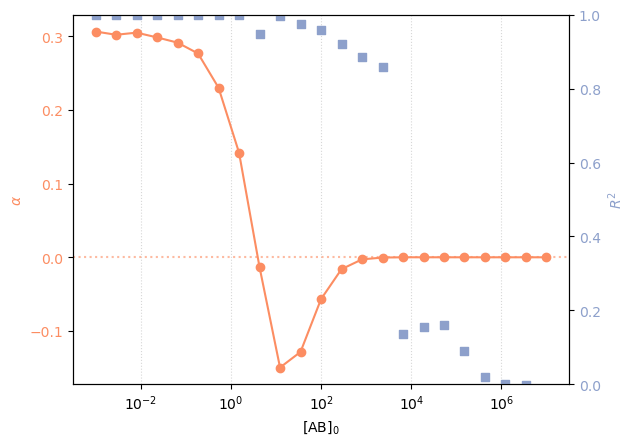

In [ ]:
barrido_ab_k1_1 = load_streamed_pickle("../barrido_ab0_k1_1.pkl")

fit = get_alpha_global(barrido_ab_k1_1)

fig, ax1 = plt.subplots()

ax1.set_xlabel(r'$[\text{AB}]_0$') 
ax1.set_ylabel(r'$\alpha$', color=colors[1])
ax1.plot(fit['Condition'], fit['Alpha'], 
            color=colors[1], marker='o')

ax1.tick_params(axis='y', labelcolor=colors[1])
ax1.grid(True, linestyle=':', alpha=0.5, which='both', axis='x')
ax1.axhline(y= 0, color= colors[1], alpha= 0.6, linestyle=":")
ax1.set_xscale('log')

ax2 = ax1.twinx()  

ax2.set_ylabel(r'$R^2$', color=colors[2])  
ax2.scatter(fit['Condition'], fit['R^2'], 
            color=colors[2], marker='s')
ax2.tick_params(axis='y', labelcolor=colors[2])
ax2.set_ylim((0,1.0))
ax2.set_xscale('log')


### DRAGO

#### k1 = 1e-4

In [23]:
results = load_streamed_pickle("../barrido_ab0_k1_0.0001_stream2.pkl")
results.keys()
len(results)

Successfully loaded 22 simulation results.


22

       Condition    Alpha_mean     Alpha_std   R2_mean
0   1.000000e-04  3.544334e-01  4.401329e-03  0.999552
1   2.848036e-04  3.527264e-01  7.080806e-03  0.999672
2   8.111308e-04  3.556383e-01  8.485436e-03  0.999661
3   2.310130e-03  3.531653e-01  3.960909e-03  0.999691
4   6.579332e-03  3.530941e-01  7.030304e-03  0.999677
5   1.873817e-02  3.548950e-01  5.528898e-03  0.999491
6   5.336699e-02  3.507997e-01  8.217452e-03  0.999563
7   1.519911e-01  3.382710e-01  8.723855e-03  0.999585
8   4.328761e-01  3.148542e-01  8.603281e-03  0.999381
9   1.232847e+00  2.545507e-01  9.255256e-03  0.999020
10  3.511192e+00  1.615150e-01  5.672392e-03  0.997050
11  1.000000e+01  7.204830e-02  7.690249e-03  0.987666
12  2.848036e+01  2.612534e-02  2.669657e-03  0.971184
13  8.111308e+01  9.488084e-03  7.954055e-04  0.953532
14  2.310130e+02  3.237219e-03  2.015453e-04  0.944724
15  6.579332e+02  1.093683e-03  9.784008e-05  0.928952
16  1.873817e+03  3.905452e-04  3.414718e-05  0.921502
17  5.3366

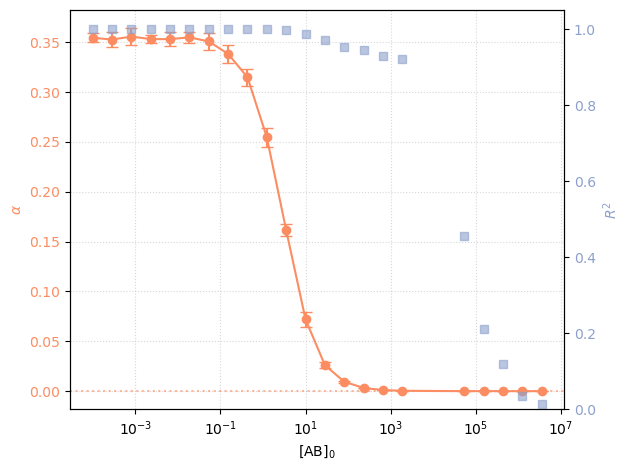

In [24]:
# 1. Processing the statistical data
# Assuming barrido_ab_k1_em4 is a dict: {concentration: [(ab, t, v), (ab, t, v), ...]}
stats_results = []

for condition, replicates in results.items():
    alphas = []
    r2_values = []
    if not isinstance(replicates, tuple):
        for rep in replicates:
            # If rep is a dictionary {cond: (ab, t, v)}, get the tuple:
            if isinstance(rep, dict):
                # This gets the first value in the dict, which is your (ab, t, v) tuple
                data_tuple = list(rep.values())[0]
            else:
                data_tuple = rep
                
            res = get_alpha_single_run(condition, data_tuple) 
            alphas.append(res['Alpha'])
            r2_values.append(res['R^2'])
    else:
        res = get_alpha_single_run(condition, replicates) 
        alphas.append(res['Alpha'])
        r2_values.append(res['R^2'])
    
    stats_results.append({
        'Condition': condition,
        'Alpha_mean': np.mean(alphas),
        'Alpha_std': np.std(alphas),
        'R2_mean': np.mean(r2_values)
    })

# Convert to DataFrame or Sortable List for plotting
stats_results = pd.DataFrame(stats_results).sort_values('Condition')
print(stats_results)

# 2. Plotting with Error Bars
fig, ax1 = plt.subplots()

# Primary Axis: Alpha with Error Bars
ax1.set_xlabel(r'$[\text{AB}]_0$') 
ax1.set_ylabel(r'$\alpha$', color=colors[1])

ax1.errorbar(stats_results['Condition'], stats_results['Alpha_mean'], 
             yerr=stats_results['Alpha_std'], 
             fmt='o-', color=colors[1], capsize=4, label=r'Mean $\alpha$')

ax1.tick_params(axis='y', labelcolor=colors[1])
ax1.grid(True, linestyle=':', alpha=0.5, which='both')
ax1.axhline(y=0, color=colors[1], alpha=0.6, linestyle=":")
ax1.set_xscale('log')

# Secondary Axis: R^2
ax2 = ax1.twinx()  
ax2.set_ylabel(r'$R^2$', color=colors[2])  
ax2.scatter(stats_results['Condition'], stats_results['R2_mean'], 
            color=colors[2], marker='s', alpha=0.6)

ax2.tick_params(axis='y', labelcolor=colors[2])
ax2.set_ylim((0, 1.05))
ax2.set_xscale('log')

fig.tight_layout()
plt.show()

Regression completed. Fitted Scaling Constant A: 99.995
Fitted exponential rate m (alpha): 0.000
Coefficient of Determination (R^2): 0.9381


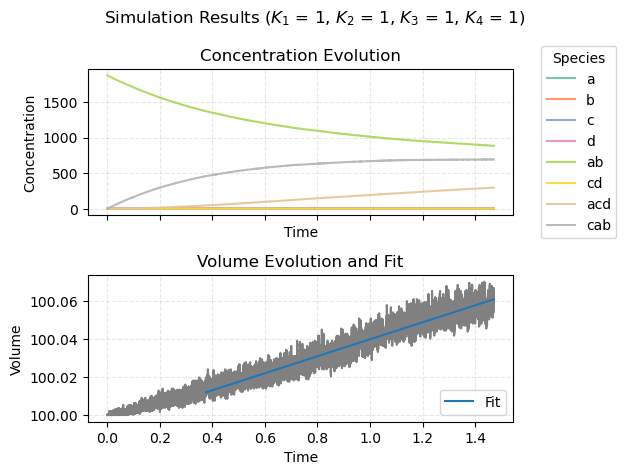

Plot generated successfully.


In [27]:
results.keys()
a, t, v = results[1873.817422860383][0]
plot_ajuste(a, t, v, species)

#### k1 = 1

Successfully loaded 15 simulation results.
        Condition  Alpha_mean  Alpha_std   R2_mean
0        0.100000    0.287569   0.006554  0.999229
1        0.268270    0.265658   0.007120  0.999091
2        0.719686    0.206808   0.007857  0.998379
3        1.930698    0.107555   0.012068  0.991641
4        5.179475   -0.028181   0.010264  0.788939
5       13.894955   -0.084930   0.050463 -4.344094
6       37.275937   -0.112296   0.104885 -3.483982
7      100.000000   -0.150590   0.070336  0.976488
8      268.269580   -0.153448   0.090994  0.976857
9      719.685673   -0.099712   0.010416  0.973013
10    1930.697729   -0.078971   0.006336  0.968152
11    5179.474679   -0.062056   0.001708  0.963961
12   13894.954944   -0.018896   0.000124  0.943317
13   37275.937203   -0.004315   0.000070  0.928003
14  100000.000000   -0.000793   0.000028  0.915464


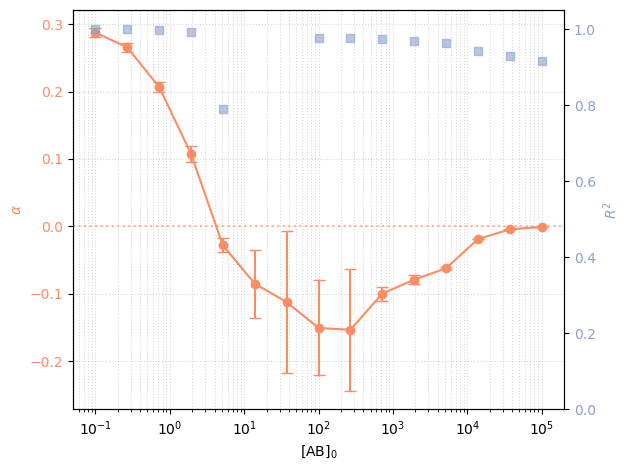

In [19]:
results = load_streamed_pickle("../barrido_ab0_k1_1_stream2.pkl")
results.keys()
len(results)
# 1. Processing the statistical data
# Assuming barrido_ab_k1_em4 is a dict: {concentration: [(ab, t, v), (ab, t, v), ...]}
stats_results = []

for condition, replicates in results.items():
    alphas = []
    r2_values = []
    if not isinstance(replicates, tuple):
        for rep in replicates:
            # If rep is a dictionary {cond: (ab, t, v)}, get the tuple:
            if isinstance(rep, dict):
                # This gets the first value in the dict, which is your (ab, t, v) tuple
                data_tuple = list(rep.values())[0]
            else:
                data_tuple = rep
                
            res = get_alpha_single_run(condition, data_tuple) 
            alphas.append(res['Alpha'])
            r2_values.append(res['R^2'])
    else:
        res = get_alpha_single_run(condition, replicates) 
        alphas.append(res['Alpha'])
        r2_values.append(res['R^2'])
    
    stats_results.append({
        'Condition': condition,
        'Alpha_mean': np.mean(alphas),
        'Alpha_std': np.std(alphas),
        'R2_mean': np.mean(r2_values)
    })

# Convert to DataFrame or Sortable List for plotting
stats_results = pd.DataFrame(stats_results).sort_values('Condition')
print(stats_results)

# 2. Plotting with Error Bars
fig, ax1 = plt.subplots()

# Primary Axis: Alpha with Error Bars
ax1.set_xlabel(r'$[\text{AB}]_0$') 
ax1.set_ylabel(r'$\alpha$', color=colors[1])

ax1.errorbar(stats_results['Condition'], stats_results['Alpha_mean'], 
             yerr=stats_results['Alpha_std'], 
             fmt='o-', color=colors[1], capsize=4, label=r'Mean $\alpha$')

ax1.tick_params(axis='y', labelcolor=colors[1])
ax1.grid(True, linestyle=':', alpha=0.5, which='both')
ax1.axhline(y=0, color=colors[1], alpha=0.6, linestyle=":")
ax1.set_xscale('log')

# Secondary Axis: R^2
ax2 = ax1.twinx()  
ax2.set_ylabel(r'$R^2$', color=colors[2])  
ax2.scatter(stats_results['Condition'], stats_results['R2_mean'], 
            color=colors[2], marker='s', alpha=0.6)

ax2.tick_params(axis='y', labelcolor=colors[2])
ax2.set_ylim((0, 1.05))
ax2.set_xscale('log')

fig.tight_layout()
plt.show()

Regression completed. Fitted Scaling Constant A: 100.002
Fitted exponential rate m (alpha): -0.001
Coefficient of Determination (R^2): 0.9247


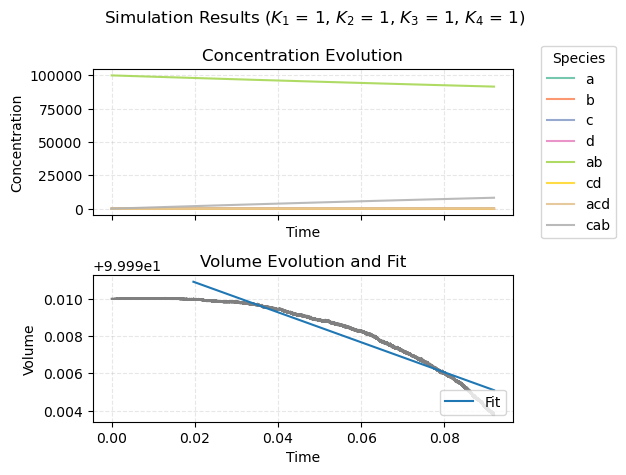

Plot generated successfully.


In [22]:
results.keys()
a, t, v = results[100000.0][0]
plot_ajuste(a, t, v, species)

#### k1 = 1e4

Successfully loaded 10 simulation results.
    Condition    Alpha_mean     Alpha_std    R2_mean
0    0.100000  5.450811e-03  4.446917e-03   0.674634
1    0.268270  9.662106e-04  1.207180e-03   0.348950
2    0.719686 -1.275476e-03  9.828214e-04   0.378105
3    1.930698 -8.689953e-03  2.162986e-03   0.411793
4    5.179475 -3.023000e-02  2.640133e-03   0.482315
5   13.894955 -5.588227e-02  2.037853e-02   0.518671
6   37.275937  1.327229e-07  3.981687e-07 -10.527858
7  100.000000 -4.335812e-01  3.438093e-01   0.883547
8  268.269580 -7.231549e-01  1.500453e-02   0.991834
9  719.685673 -7.209951e-01  1.082115e-02   0.992587


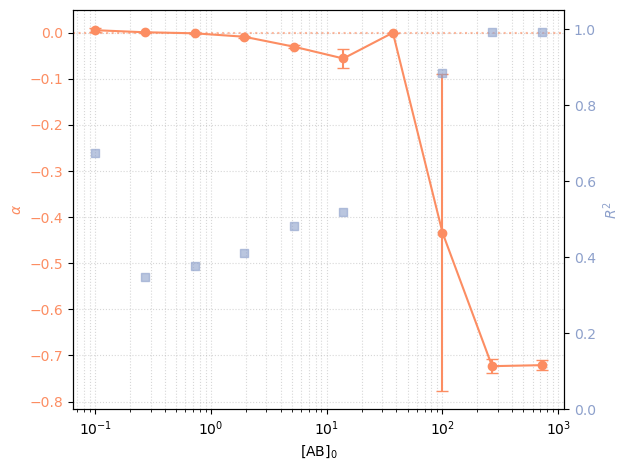

In [14]:
results = load_streamed_pickle("../barrido_ab0_k1_10000.0_stream2.pkl")
results.keys()
len(results)
# 1. Processing the statistical data
# Assuming barrido_ab_k1_em4 is a dict: {concentration: [(ab, t, v), (ab, t, v), ...]}
stats_results = []

for condition, replicates in results.items():
    alphas = []
    r2_values = []
    if not isinstance(replicates, tuple):
        for rep in replicates:
            # If rep is a dictionary {cond: (ab, t, v)}, get the tuple:
            if isinstance(rep, dict):
                # This gets the first value in the dict, which is your (ab, t, v) tuple
                data_tuple = list(rep.values())[0]
            else:
                data_tuple = rep
                
            res = get_alpha_single_run(condition, data_tuple) 
            alphas.append(res['Alpha'])
            r2_values.append(res['R^2'])
    else:
        res = get_alpha_single_run(condition, replicates) 
        alphas.append(res['Alpha'])
        r2_values.append(res['R^2'])
    
    stats_results.append({
        'Condition': condition,
        'Alpha_mean': np.mean(alphas),
        'Alpha_std': np.std(alphas),
        'R2_mean': np.mean(r2_values)
    })

# Convert to DataFrame or Sortable List for plotting
stats_results = pd.DataFrame(stats_results).sort_values('Condition')
print(stats_results)

# 2. Plotting with Error Bars
fig, ax1 = plt.subplots()

# Primary Axis: Alpha with Error Bars
ax1.set_xlabel(r'$[\text{AB}]_0$') 
ax1.set_ylabel(r'$\alpha$', color=colors[1])

ax1.errorbar(stats_results['Condition'], stats_results['Alpha_mean'], 
             yerr=stats_results['Alpha_std'], 
             fmt='o-', color=colors[1], capsize=4, label=r'Mean $\alpha$')

ax1.tick_params(axis='y', labelcolor=colors[1])
ax1.grid(True, linestyle=':', alpha=0.5, which='both')
ax1.axhline(y=0, color=colors[1], alpha=0.6, linestyle=":")
ax1.set_xscale('log')

# Secondary Axis: R^2
ax2 = ax1.twinx()  
ax2.set_ylabel(r'$R^2$', color=colors[2])  
ax2.scatter(stats_results['Condition'], stats_results['R2_mean'], 
            color=colors[2], marker='s', alpha=0.6)

ax2.tick_params(axis='y', labelcolor=colors[2])
ax2.set_ylim((0, 1.05))
ax2.set_xscale('log')

fig.tight_layout()
plt.show()

In [15]:
def load_list_pickle(filename):
    data = []
    try:
        with open(filename, "rb") as file:
            while True:
                try:
                    # Load one object (which is a dict of {k_i: (abundances, times, volumes)})
                    chunk = pickle.load(file)
                    # Merge the loaded chunk into the main dictionary
                    data.append(chunk)
                except EOFError:
                    # Reached the end of the file
                    break
    except FileNotFoundError:
        print(f"Error: File '{filename}' not found.")
    
    print(f"Successfully loaded {len(data)} simulation results.")
    return data
a, t, v = load_list_pickle('../gillespie_chemostat.pkl')


Successfully loaded 1 simulation results.


ValueError: not enough values to unpack (expected 3, got 1)

## ajuste k_0

(0.0, 1.0)

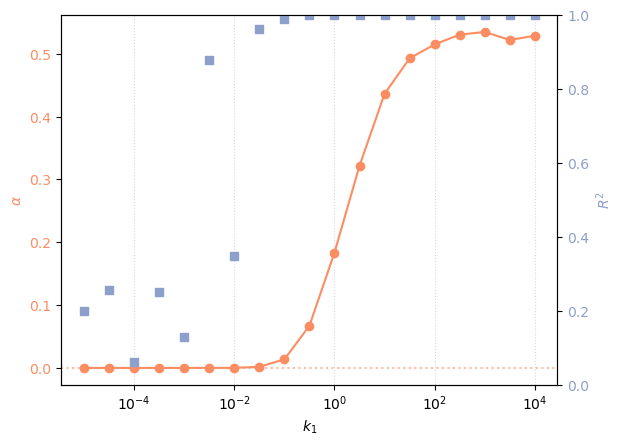

In [ ]:
fit = get_alpha_global(barrido_k0)
fig, ax1 = plt.subplots()

ax1.set_xlabel(r'$k_1$') 
ax1.set_ylabel(r'$\alpha$', color=colors[1])
ax1.plot(fit['Condition'], fit['Alpha'], 
            color=colors[1], marker='o')
ax1.set_xscale('log')

ax1.tick_params(axis='y', labelcolor=colors[1])
ax1.grid(True, linestyle=':', alpha=0.5, which='both', axis='x')
ax1.axhline(y= 0, color= colors[1], alpha= 0.6, linestyle=":")

ax2 = ax1.twinx()  

ax2.set_ylabel(r'$R^2$', color=colors[2])  
ax2.scatter(fit['Condition'], fit['R^2'], 
            color=colors[2], marker='s')
ax2.tick_params(axis='y', labelcolor=colors[2])
ax2.set_xscale('log')
ax2.set_ylim((0,1.0))

In [ ]:
barrido_k0.keys()

dict_keys([0.001, 0.0031622776601683794, 0.01, 0.03162277660168379, 0.1, 0.31622776601683794, 1.0, 3.1622776601683795, 10.0, 31.622776601683793, 100.0, 316.22776601683796, 1000.0, 3162.2776601683795, 10000.0, 1e-05, 3.1622776601683795e-05, 0.0001, 0.00031622776601683794])

In [ ]:
for k_i in [1e-05, 0.001, 0.0031622776601683794, 0.01, 0.03162277660168379, 0.1]:
    k = [k_i] + [1]*2 + [1]*5
    print(k_i)
    abundances, times, volumes = barrido_k0[k_i]
    plot_ajuste(abundances[:,4:], times, volumes, species[4:])

## ajuste k_1

Successfully loaded 25 simulation results.
       Condition     Alpha  Scaling Const. (A)       R^2
0   1.000000e-05  0.272938          817.841344  0.999882
1   3.162278e-05  0.262611          850.244108  0.999923
2   1.000000e-04  0.267316          861.440073  0.999918
3   3.162278e-04  0.265525          845.428785  0.999841
4   1.000000e-03  0.270439          799.568844  0.999900
5   3.162278e-03  0.272251          865.424765  0.999857
6   1.000000e-02  0.269123          842.870734  0.999869
7   3.162278e-02  0.263237          878.442050  0.999824
8   1.000000e-01  0.265209          856.168619  0.999830
9   3.162278e-01  0.233848          911.649192  0.999876
10  1.000000e+00  0.185079          845.245237  0.999772
11  3.162278e+00  0.074255          877.366617  0.998224
12  1.000000e+01  0.011320          886.222192  0.972965
13  3.162278e+01  0.000246          670.439921  0.034228
14  1.000000e+02  0.000405          691.720604  0.161501
15  3.162278e+02  0.000733          588.10948

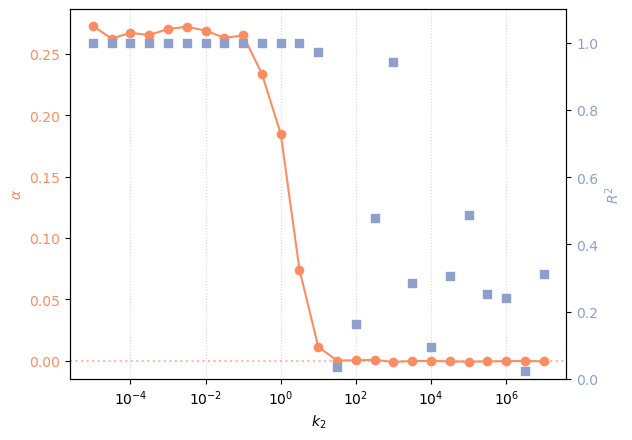

In [ ]:
barrido_k1 = load_streamed_pickle("../barrido_k1_stream.pkl")
fit = get_alpha_global(barrido_k1)

fig, ax1 = plt.subplots()

ax1.set_xlabel(r'$k_2$') 
ax1.set_ylabel(r'$\alpha$', color=colors[1])
ax1.plot(fit['Condition'], fit['Alpha'], 
            color=colors[1], marker='o')

ax1.tick_params(axis='y', labelcolor=colors[1])
ax1.grid(True, linestyle=':', alpha=0.5, which='both', axis='x')
ax1.axhline(y= 0, color= colors[1], alpha= 0.6, linestyle=":")
ax1.set_xscale('log')

ax2 = ax1.twinx()  

ax2.set_ylabel(r'$R^2$', color=colors[2])  
ax2.scatter(fit['Condition'], fit['R^2'], 
            color=colors[2], marker='s')
ax2.tick_params(axis='y', labelcolor=colors[2])
ax2.set_ylim((0,1.1))
ax2.set_xscale('log')

print(fit)

Regression completed. Fitted Scaling Constant A: 691.721
Fitted exponential rate m (alpha): 0.000
Coefficient of Determination (R^2): 0.1615


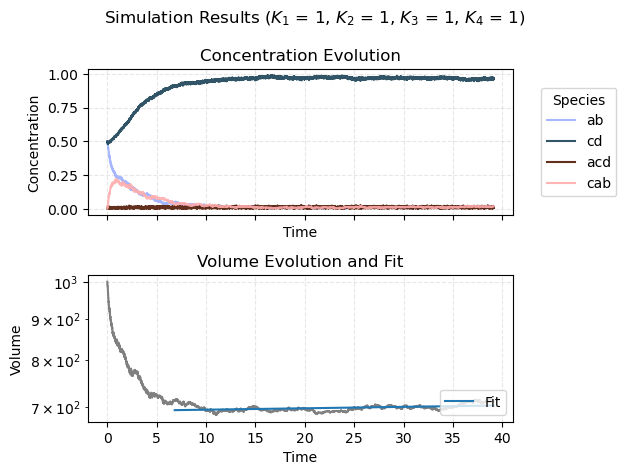

Plot generated successfully.


1000.0

In [ ]:
abundances, times, volumes = barrido_k1[1e02]
plot_ajuste(abundances[:,4:], times, volumes, species[4:])
volumes[0]

## ajuste k_2

In [ ]:
barrido_k2.keys()

dict_keys([0.001, 0.0031622776601683794, 0.01, 0.03162277660168379, 0.1, 0.31622776601683794, 1.0, 3.1622776601683795, 10.0, 31.622776601683793, 100.0, 316.22776601683796, 1000.0, 3162.2776601683795, 10000.0, 1e-07, 1e-06, 1e-05, 0.0001, 3.1622776601683795e-05, 0.00031622776601683794])

       Condition         Alpha  Scaling Const. (A)           R^2
15  1.000000e-07 -1.326402e-16          919.000000 -7.005325e+05
16  1.000000e-06  2.189667e-16         1016.000000 -1.607091e+06
17  1.000000e-05  5.329065e-06          907.526236  1.678024e-01
19  3.162278e-05  4.541781e-06          929.336346  1.155428e-01
18  1.000000e-04  1.577149e-05          930.994545  5.316187e-01
20  3.162278e-04  2.684032e-05          911.228657  4.069051e-01
0   1.000000e-03  1.848539e-04          950.299136  9.396208e-01
1   3.162278e-03  8.055052e-04          888.159096  9.827918e-01
2   1.000000e-02  2.578142e-03          877.828639  9.972989e-01
3   3.162278e-02  9.157762e-03          897.879996  9.976777e-01
4   1.000000e-01  2.868483e-02          932.810526  9.976683e-01
5   3.162278e-01  8.770090e-02          871.209346  9.981024e-01
6   1.000000e+00  1.750321e-01          897.819198  9.996082e-01
7   3.162278e+00  2.772591e-01          956.981122  9.997795e-01
8   1.000000e+01  3.44812

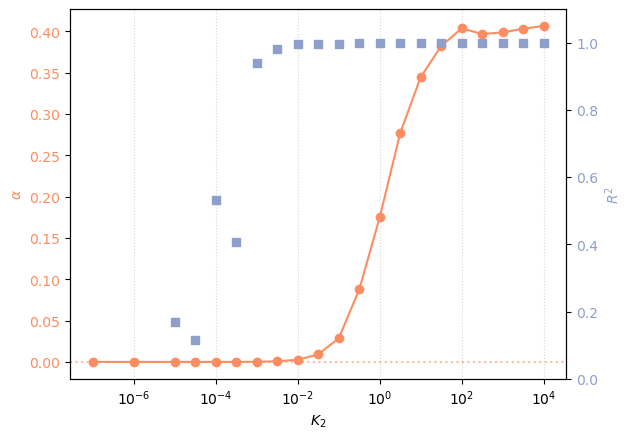

In [ ]:
fit = get_alpha_global(barrido_k2)
fig, ax1 = plt.subplots()

ax1.set_xlabel(r'$K_2$') 
ax1.set_ylabel(r'$\alpha$', color=colors[1])
ax1.plot(fit['Condition'], fit['Alpha'], 
            color=colors[1], marker='o')
ax1.set_xscale('log')

ax1.tick_params(axis='y', labelcolor=colors[1])
ax1.grid(True, linestyle=':', alpha=0.5, which='both', axis='x')
ax1.axhline(y= 0, color= colors[1], alpha= 0.6, linestyle=":")

ax2 = ax1.twinx()  

ax2.set_ylabel(r'$R^2$', color=colors[2])  
ax2.scatter(fit['Condition'], fit['R^2'], 
            color=colors[2], marker='s')
ax2.tick_params(axis='y', labelcolor=colors[2])
ax2.set_ylim((0,1.1))
print(fit)

In [ ]:
barrido_k2.keys()

dict_keys([0.001, 0.0031622776601683794, 0.01, 0.03162277660168379, 0.1, 0.31622776601683794, 1.0, 3.1622776601683795, 10.0, 31.622776601683793, 100.0, 316.22776601683796, 1000.0, 3162.2776601683795, 10000.0, 1e-05, 0.0001, 3.1622776601683795e-05, 0.00031622776601683794])

In [ ]:
for k_i in [1e-05,1e-02, 1]:
    k = [1]*2 + [k_i] + [1]*5
    abundances, times, volumes = barrido_k2[k_i]
    plot_ajuste(abundances, times, volumes, species)

In [ ]:
simulations_k2_loaded = load_streamed_pickle("../barrido_k2_stream.pkl")
k = [1,1,1,1,1,1,1,1]
for k_i in simulations_k2_loaded.keys():
    k[2] = k_i
    abundances, times, volumes = simulations_k2_loaded[k_i]
    plot_ajuste(abundances, times, volumes, species)

## ajuste k_3

Successfully loaded 25 simulation results.
       Condition         Alpha  Scaling Const. (A)           R^2
0   1.000000e-05  2.343990e-01          847.656494  9.998794e-01
1   3.162278e-05  2.376207e-01          900.396225  9.997444e-01
2   1.000000e-04  2.294402e-01          859.870259  9.998960e-01
3   3.162278e-04  2.379422e-01          879.263061  9.998911e-01
4   1.000000e-03  2.412386e-01          833.373274  9.999063e-01
5   3.162278e-03  2.358932e-01          919.293517  9.997107e-01
6   1.000000e-02  2.345936e-01          884.142493  9.997834e-01
7   3.162278e-02  2.386321e-01          868.768167  9.999338e-01
8   1.000000e-01  2.228909e-01          895.784220  9.998477e-01
9   3.162278e-01  2.201110e-01          827.741287  9.997210e-01
10  1.000000e+00  1.763954e-01          814.337751  9.995912e-01
11  3.162278e+00  1.026824e-01          831.164210  9.992597e-01
12  1.000000e+01  3.182281e-02          567.449120  9.980258e-01
13  3.162278e+01  7.906695e-03          585.092

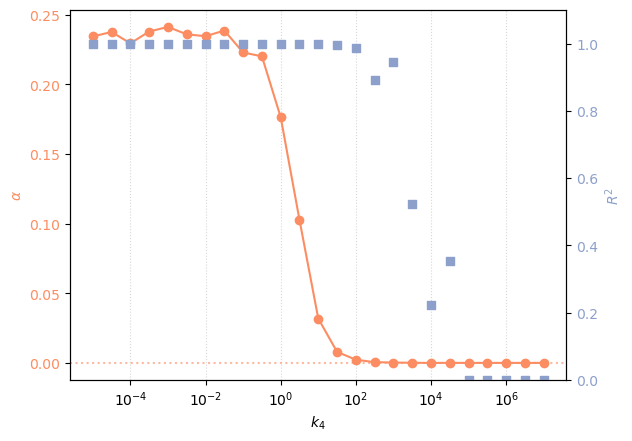

In [ ]:
barrido_k3 = load_streamed_pickle("../barrido_k3_stream.pkl")
fit = get_alpha_global(barrido_k3)

fig, ax1 = plt.subplots()

ax1.set_xlabel(r'$k_4$') 
ax1.set_ylabel(r'$\alpha$', color=colors[1])
ax1.plot(fit['Condition'], fit['Alpha'], 
            color=colors[1], marker='o')

ax1.tick_params(axis='y', labelcolor=colors[1])
ax1.grid(True, linestyle=':', alpha=0.5, which='both', axis='x')
ax1.axhline(y= 0, color= colors[1], alpha= 0.6, linestyle=":")
ax1.set_xscale('log')

ax2 = ax1.twinx()  

ax2.set_ylabel(r'$R^2$', color=colors[2])  
ax2.scatter(fit['Condition'], fit['R^2'], 
            color=colors[2], marker='s')
ax2.tick_params(axis='y', labelcolor=colors[2])
ax2.set_ylim((0,1.1))
ax2.set_xscale('log')
print(fit)


## ajuste k_4

Successfully loaded 25 simulation results.
       Condition         Alpha  Scaling Const. (A)       R^2
0   1.000000e-05  2.287129e-08          783.801161  0.058672
1   3.162278e-05  1.362134e-07          806.823447  0.152190
2   1.000000e-04 -1.258529e-06          800.690693  0.460461
3   3.162278e-04 -4.156732e-06          747.609087  0.618807
4   1.000000e-03 -1.929140e-05          718.578114  0.897791
5   3.162278e-03  5.928302e-07          775.105085  0.000416
6   1.000000e-02  2.830776e-04          800.747888  0.905362
7   3.162278e-02  1.001262e-03          748.585121  0.934415
8   1.000000e-01  1.149644e-02          900.729397  0.983331
9   3.162278e-01  7.048808e-02          894.225462  0.998895
10  1.000000e+00  1.848042e-01          839.886908  0.999544
11  3.162278e+00  3.232787e-01          846.203954  0.999880
12  1.000000e+01  4.287737e-01          956.467062  0.999934
13  3.162278e+01  5.024795e-01          919.367786  0.999866
14  1.000000e+02  5.189746e-01          99

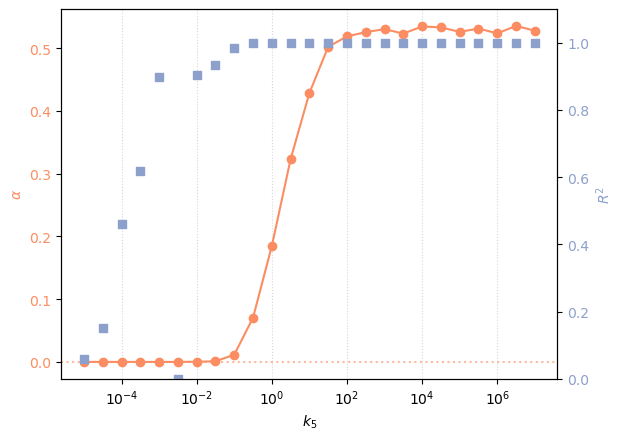

In [ ]:
barrido_k4 = load_streamed_pickle("../barrido_k4_stream.pkl")
fit = get_alpha_global(barrido_k4)

fig, ax1 = plt.subplots()

ax1.set_xlabel(r'$k_5$') 
ax1.set_ylabel(r'$\alpha$', color=colors[1])
ax1.plot(fit['Condition'], fit['Alpha'], 
            color=colors[1], marker='o')

ax1.tick_params(axis='y', labelcolor=colors[1])
ax1.grid(True, linestyle=':', alpha=0.5, which='both', axis='x')
ax1.axhline(y= 0, color= colors[1], alpha= 0.6, linestyle=":")
ax1.set_xscale('log')

ax2 = ax1.twinx()  

ax2.set_ylabel(r'$R^2$', color=colors[2])  
ax2.scatter(fit['Condition'], fit['R^2'], 
            color=colors[2], marker='s')
ax2.tick_params(axis='y', labelcolor=colors[2])
ax2.set_ylim((0,1.1))
ax2.set_xscale('log')
print(fit)


## ajuste k_5

Successfully loaded 25 simulation results.
       Condition     Alpha  Scaling Const. (A)       R^2
0   1.000000e-05  0.264522          807.346601  0.999881
1   3.162278e-05  0.264681          854.680758  0.999809
2   1.000000e-04  0.271229          834.973040  0.999945
3   3.162278e-04  0.262856          837.001170  0.999921
4   1.000000e-03  0.270822          850.967734  0.999909
5   3.162278e-03  0.266502          784.669260  0.999764
6   1.000000e-02  0.263388          847.768798  0.999769
7   3.162278e-02  0.266326          851.060715  0.999909
8   1.000000e-01  0.260590          858.267905  0.999838
9   3.162278e-01  0.233401          872.424959  0.999788
10  1.000000e+00  0.187252          834.158122  0.998750
11  3.162278e+00  0.079846          922.927217  0.997463
12  1.000000e+01  0.016663          829.844518  0.994121
13  3.162278e+01  0.004179          761.521346  0.918707
14  1.000000e+02 -0.000301          628.409373  0.186246
15  3.162278e+02 -0.000618          625.76265

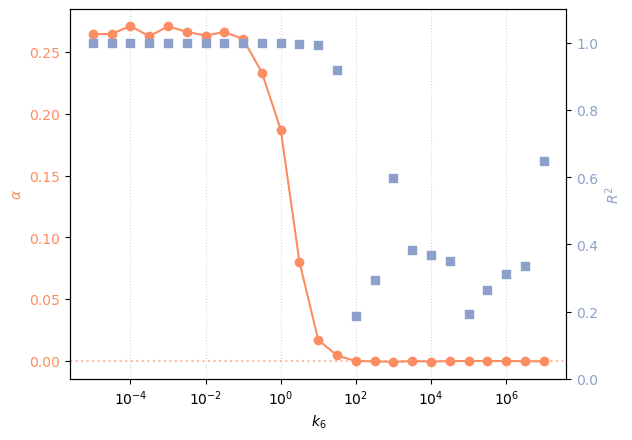

In [ ]:
barrido_k5 = load_streamed_pickle("../barrido_k5_stream.pkl")
fit = get_alpha_global(barrido_k5)

fig, ax1 = plt.subplots()

ax1.set_xlabel(r'$k_6$') 
ax1.set_ylabel(r'$\alpha$', color=colors[1])
ax1.plot(fit['Condition'], fit['Alpha'], 
            color=colors[1], marker='o')

ax1.tick_params(axis='y', labelcolor=colors[1])
ax1.grid(True, linestyle=':', alpha=0.5, which='both', axis='x')
ax1.axhline(y= 0, color= colors[1], alpha= 0.6, linestyle=":")
ax1.set_xscale('log')

ax2 = ax1.twinx()  

ax2.set_ylabel(r'$R^2$', color=colors[2])  
ax2.scatter(fit['Condition'], fit['R^2'], 
            color=colors[2], marker='s')
ax2.tick_params(axis='y', labelcolor=colors[2])
ax2.set_ylim((0,1.1))
ax2.set_xscale('log')
print(fit)


## ajuste k6

Successfully loaded 25 simulation results.
       Condition         Alpha  Scaling Const. (A)           R^2
0   1.000000e-05 -5.869566e-17          932.000000 -23077.071777
1   3.162278e-05  5.775004e-07          918.964568      0.022576
2   1.000000e-04  6.686223e-05          886.206995      0.799124
3   3.162278e-04  9.951141e-05          896.851927      0.930086
4   1.000000e-03  2.488050e-04          962.488009      0.942080
5   3.162278e-03  8.043187e-04          907.881864      0.976090
6   1.000000e-02  3.370774e-03          915.159724      0.985241
7   3.162278e-02  8.846459e-03          925.291889      0.994584
8   1.000000e-01  3.040851e-02          962.740964      0.999245
9   3.162278e-01  8.695070e-02          932.278192      0.999450
10  1.000000e+00  1.825082e-01          832.216919      0.999795
11  3.162278e+00  2.806524e-01          868.759525      0.999801
12  1.000000e+01  3.505685e-01          941.860554      0.999864
13  3.162278e+01  3.860989e-01          955.140

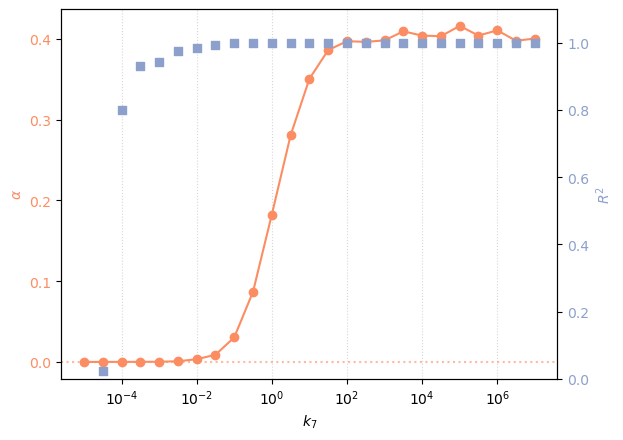

In [ ]:
barrido_k6 = load_streamed_pickle("../barrido_k6_stream.pkl")
fit = get_alpha_global(barrido_k6)

fig, ax1 = plt.subplots()

ax1.set_xlabel(r'$k_7$') 
ax1.set_ylabel(r'$\alpha$', color=colors[1])
ax1.plot(fit['Condition'], fit['Alpha'], 
            color=colors[1], marker='o')

ax1.tick_params(axis='y', labelcolor=colors[1])
ax1.grid(True, linestyle=':', alpha=0.5, which='both', axis='x')
ax1.axhline(y= 0, color= colors[1], alpha= 0.6, linestyle=":")
ax1.set_xscale('log')

ax2 = ax1.twinx()  

ax2.set_ylabel(r'$R^2$', color=colors[2])  
ax2.scatter(fit['Condition'], fit['R^2'], 
            color=colors[2], marker='s')
ax2.tick_params(axis='y', labelcolor=colors[2])
ax2.set_ylim((0,1.1))
ax2.set_xscale('log')
print(fit)


## ajuste k_7

Successfully loaded 25 simulation results.
       Condition         Alpha  Scaling Const. (A)           R^2
0   1.000000e-05  2.332875e-01          864.245034  9.998966e-01
1   3.162278e-05  2.373018e-01          881.375799  9.998848e-01
2   1.000000e-04  2.414124e-01          820.138620  9.999021e-01
3   3.162278e-04  2.374296e-01          855.675155  9.998666e-01
4   1.000000e-03  2.359767e-01          880.873052  9.998964e-01
5   3.162278e-03  2.292571e-01          892.275126  9.999227e-01
6   1.000000e-02  2.403792e-01          870.480846  9.998694e-01
7   3.162278e-02  2.333718e-01          877.754117  9.998865e-01
8   1.000000e-01  2.303713e-01          898.436067  9.997861e-01
9   3.162278e-01  2.141182e-01          914.134429  9.997163e-01
10  1.000000e+00  1.778342e-01          881.380303  9.996127e-01
11  3.162278e+00  1.020333e-01          790.857720  9.969621e-01
12  1.000000e+01  2.926903e-02          666.410125  9.971514e-01
13  3.162278e+01  7.756866e-03          577.002

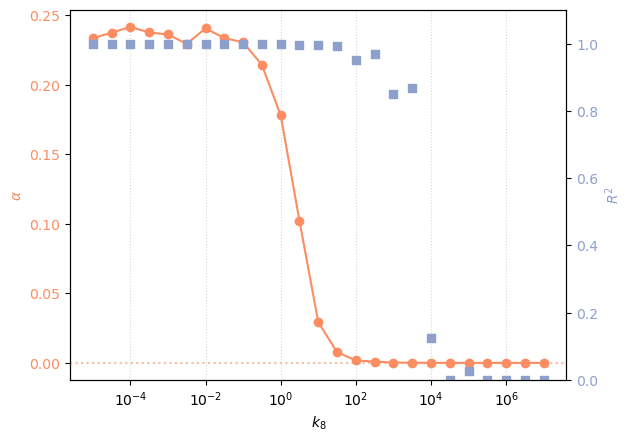

In [ ]:
barrido_k7 = load_streamed_pickle("../barrido_k7_stream.pkl")
fit = get_alpha_global(barrido_k7)

fig, ax1 = plt.subplots()

ax1.set_xlabel(r'$k_8$') 
ax1.set_ylabel(r'$\alpha$', color=colors[1])
ax1.plot(fit['Condition'], fit['Alpha'], 
            color=colors[1], marker='o')

ax1.tick_params(axis='y', labelcolor=colors[1])
ax1.grid(True, linestyle=':', alpha=0.5, which='both', axis='x')
ax1.axhline(y= 0, color= colors[1], alpha= 0.6, linestyle=":")
ax1.set_xscale('log')

ax2 = ax1.twinx()  

ax2.set_ylabel(r'$R^2$', color=colors[2])  
ax2.scatter(fit['Condition'], fit['R^2'], 
            color=colors[2], marker='s')
ax2.tick_params(axis='y', labelcolor=colors[2])
ax2.set_ylim((0,1.1))
ax2.set_xscale('log')
print(fit)


# DRAGO TODOOO

Successfully loaded 25 simulation results.
       Condition  Alpha_mean  Alpha_std   R2_mean
0   1.000000e-05    0.267402   0.007192  0.999125
1   3.162278e-05    0.264503   0.006011  0.999149
2   1.000000e-04    0.263209   0.008393  0.998910
3   3.162278e-04    0.268253   0.010203  0.998878
4   1.000000e-03    0.271025   0.010271  0.999212
5   3.162278e-03    0.268699   0.009123  0.999196
6   1.000000e-02    0.267615   0.008928  0.999120
7   3.162278e-02    0.266140   0.006413  0.998858
8   1.000000e-01    0.253597   0.008421  0.998909
9   3.162278e-01    0.236906   0.007214  0.998862
10  1.000000e+00    0.178374   0.012215  0.996769
11  3.162278e+00    0.087439   0.006572  0.989495
12  1.000000e+01    0.018212   0.003866  0.839888
13  3.162278e+01    0.003096   0.004362  0.434026
14  1.000000e+02    0.002671   0.002462  0.567747
15  3.162278e+02    0.000548   0.001400  0.356457
16  1.000000e+03   -0.000146   0.000266  0.139389
17  3.162278e+03   -0.000184   0.000327  0.179700
18  1.0

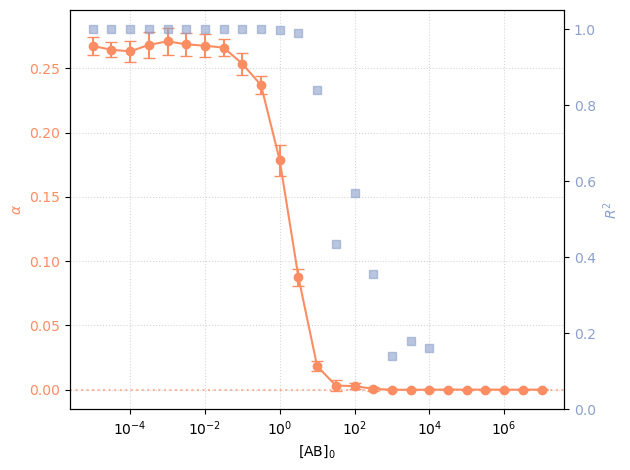

Successfully loaded 25 simulation results.
       Condition  Alpha_mean  Alpha_std   R2_mean
0   1.000000e-05   -0.000026   0.000120  0.128832
1   3.162278e-05   -0.000153   0.000185  0.204219
2   1.000000e-04    0.000157   0.000572  0.051868
3   3.162278e-04    0.000047   0.000494  0.309065
4   1.000000e-03   -0.000106   0.000170  0.144403
5   3.162278e-03    0.001205   0.000762  0.557245
6   1.000000e-02    0.003198   0.001585  0.825976
7   3.162278e-02    0.008695   0.001894  0.930486
8   1.000000e-01    0.029120   0.006262  0.974809
9   3.162278e-01    0.081883   0.008428  0.994726
10  1.000000e+00    0.179515   0.007718  0.997248
11  3.162278e+00    0.273355   0.007835  0.997550
12  1.000000e+01    0.355357   0.013921  0.998912
13  3.162278e+01    0.383638   0.014508  0.998880
14  1.000000e+02    0.390027   0.012498  0.999012
15  3.162278e+02    0.403192   0.013275  0.999242
16  1.000000e+03    0.405465   0.020985  0.998967
17  3.162278e+03    0.398699   0.013131  0.998584
18  1.0

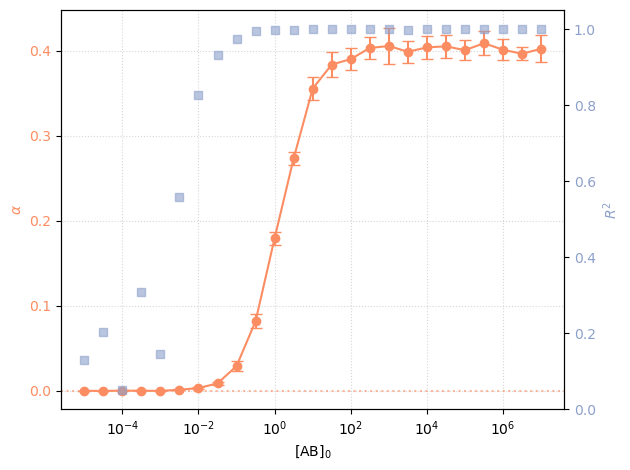

Successfully loaded 25 simulation results.
       Condition    Alpha_mean  Alpha_std   R2_mean
0   1.000000e-05  2.299402e-01   0.009014  0.998743
1   3.162278e-05  2.360085e-01   0.007377  0.998629
2   1.000000e-04  2.305199e-01   0.006988  0.998870
3   3.162278e-04  2.392130e-01   0.007400  0.998469
4   1.000000e-03  2.390626e-01   0.010063  0.999046
5   3.162278e-03  2.379227e-01   0.004611  0.998660
6   1.000000e-02  2.337301e-01   0.007009  0.998834
7   3.162278e-02  2.373915e-01   0.010546  0.998333
8   1.000000e-01  2.289936e-01   0.008656  0.998710
9   3.162278e-01  2.103453e-01   0.011035  0.998544
10  1.000000e+00  1.802763e-01   0.008045  0.997787
11  3.162278e+00  1.063367e-01   0.009172  0.992475
12  1.000000e+01  3.117145e-02   0.005107  0.956032
13  3.162278e+01  9.325638e-03   0.003543  0.858163
14  1.000000e+02  2.779767e-03   0.002459  0.552156
15  3.162278e+02  5.886225e-04   0.000927  0.378968
16  1.000000e+03  3.248468e-04   0.000530  0.267202
17  3.162278e+03  6.2

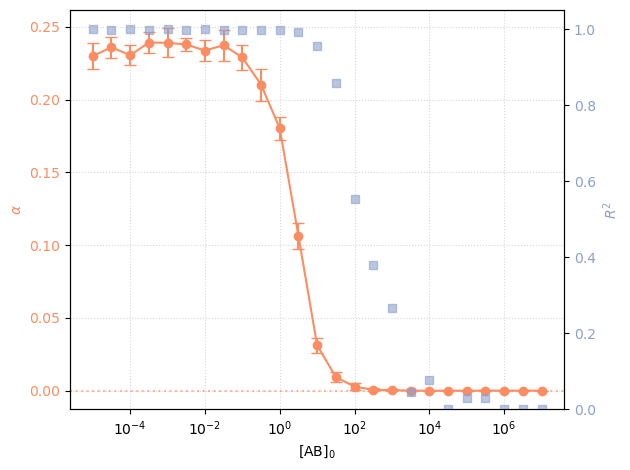

Successfully loaded 25 simulation results.
       Condition    Alpha_mean     Alpha_std   R2_mean
0   1.000000e-05  1.564389e-07  4.115976e-07  0.591826
1   3.162278e-05 -1.142273e-07  8.965734e-07  0.354853
2   1.000000e-04 -6.536438e-07  5.766892e-06  0.693596
3   3.162278e-04  5.787211e-06  1.146417e-05  0.448017
4   1.000000e-03 -3.508012e-06  3.671964e-05  0.474851
5   3.162278e-03  5.752280e-05  7.743561e-05  0.368384
6   1.000000e-02  1.543584e-04  4.696264e-04  0.460953
7   3.162278e-02  1.954280e-03  1.456598e-03  0.633818
8   1.000000e-01  1.209989e-02  3.416033e-03  0.933268
9   3.162278e-01  6.828596e-02  7.388302e-03  0.992719
10  1.000000e+00  1.793720e-01  9.132742e-03  0.997699
11  3.162278e+00  3.244906e-01  7.767379e-03  0.998713
12  1.000000e+01  4.306643e-01  1.438074e-02  0.999150
13  3.162278e+01  5.014060e-01  9.136703e-03  0.999241
14  1.000000e+02  5.087276e-01  1.307422e-02  0.999501
15  3.162278e+02  5.289822e-01  1.672337e-02  0.999357
16  1.000000e+03  5.28

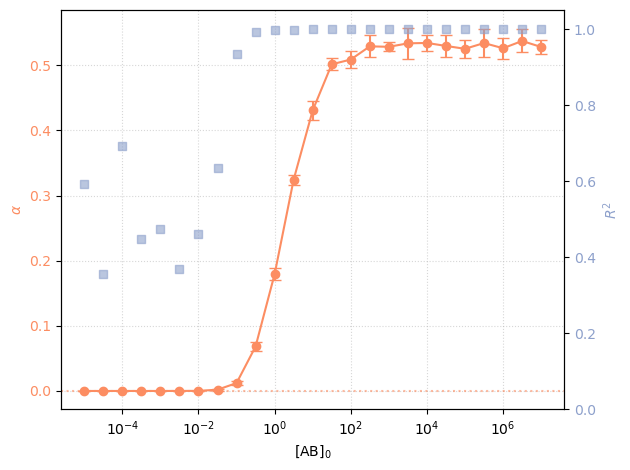

Successfully loaded 25 simulation results.
       Condition  Alpha_mean  Alpha_std   R2_mean
0   1.000000e-05    0.268201   0.008184  0.999186
1   3.162278e-05    0.270704   0.005611  0.999031
2   1.000000e-04    0.267236   0.006629  0.999023
3   3.162278e-04    0.272406   0.003585  0.999043
4   1.000000e-03    0.271117   0.009086  0.999013
5   3.162278e-03    0.265877   0.009898  0.998971
6   1.000000e-02    0.261226   0.008775  0.998918
7   3.162278e-02    0.261083   0.005025  0.998948
8   1.000000e-01    0.259733   0.008908  0.999239
9   3.162278e-01    0.234375   0.007829  0.998548
10  1.000000e+00    0.181630   0.007836  0.998004
11  3.162278e+00    0.081355   0.005458  0.987402
12  1.000000e+01    0.012428   0.006730  0.691291
13  3.162278e+01    0.001105   0.003484  0.457573
14  1.000000e+02    0.000072   0.001588  0.277399
15  3.162278e+02   -0.000501   0.001162  0.413995
16  1.000000e+03    0.000136   0.000476  0.259224
17  3.162278e+03   -0.000166   0.000274 -2.467404
18  1.0

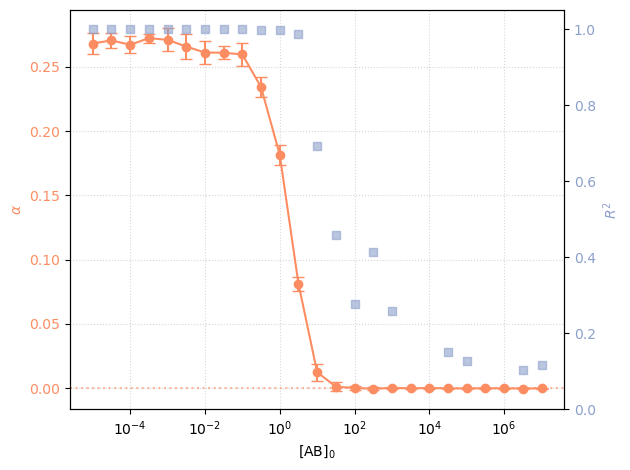

Successfully loaded 25 simulation results.
       Condition  Alpha_mean  Alpha_std   R2_mean
0   1.000000e-05   -0.000011   0.000184  0.222310
1   3.162278e-05    0.000017   0.000145 -0.082403
2   1.000000e-04    0.000178   0.000463  0.233486
3   3.162278e-04    0.000083   0.000270  0.228437
4   1.000000e-03    0.000163   0.000298  0.359022
5   3.162278e-03    0.000728   0.000540  0.475713
6   1.000000e-02    0.002607   0.000836  0.775251
7   3.162278e-02    0.009560   0.002697  0.892689
8   1.000000e-01    0.028852   0.004194  0.973243
9   3.162278e-01    0.084978   0.007116  0.994228
10  1.000000e+00    0.180314   0.009448  0.996194
11  3.162278e+00    0.280175   0.013628  0.998328
12  1.000000e+01    0.351059   0.010680  0.998799
13  3.162278e+01    0.386040   0.014047  0.998772
14  1.000000e+02    0.404006   0.014405  0.999005
15  3.162278e+02    0.407677   0.014976  0.999018
16  1.000000e+03    0.394051   0.016789  0.998827
17  3.162278e+03    0.406063   0.010018  0.998931
18  1.0

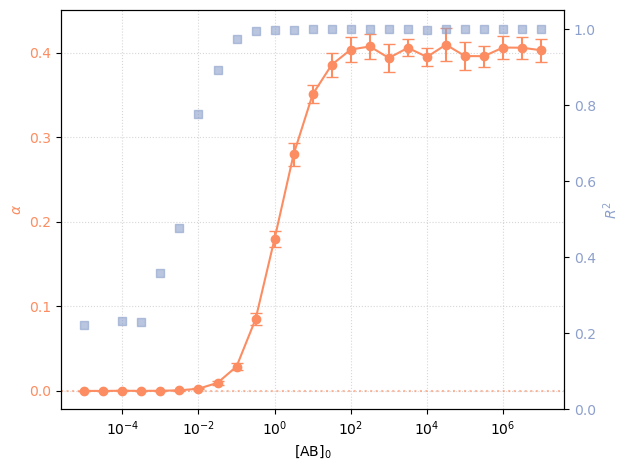

Successfully loaded 25 simulation results.
       Condition    Alpha_mean  Alpha_std   R2_mean
0   1.000000e-05  2.370864e-01   0.006486  0.998396
1   3.162278e-05  2.372878e-01   0.012242  0.998478
2   1.000000e-04  2.338052e-01   0.008659  0.998533
3   3.162278e-04  2.313895e-01   0.007664  0.998595
4   1.000000e-03  2.325670e-01   0.010863  0.998151
5   3.162278e-03  2.315195e-01   0.010014  0.998480
6   1.000000e-02  2.320085e-01   0.006784  0.998217
7   3.162278e-02  2.373648e-01   0.010757  0.998794
8   1.000000e-01  2.322334e-01   0.007962  0.998737
9   3.162278e-01  2.153986e-01   0.009472  0.998788
10  1.000000e+00  1.791197e-01   0.011175  0.997769
11  3.162278e+00  1.025361e-01   0.007497  0.992021
12  1.000000e+01  2.989136e-02   0.004408  0.943377
13  3.162278e+01  7.298446e-03   0.003204  0.781987
14  1.000000e+02  3.115207e-03   0.002243  0.595927
15  3.162278e+02  8.375973e-04   0.000991  0.359415
16  1.000000e+03  3.192295e-04   0.000550  0.277830
17  3.162278e+03  1.1

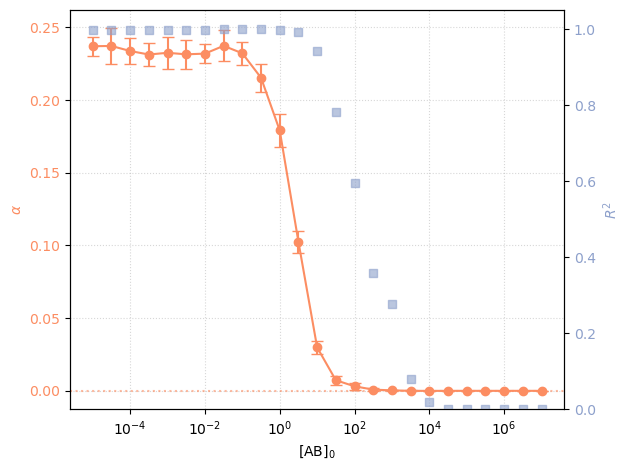

In [15]:
for i in range(1,8):
    results = load_streamed_pickle(f"../barrido_k{i}_stream2.pkl")
    results.keys()
    len(results)
    # 1. Processing the statistical data
    # Assuming barrido_ab_k1_em4 is a dict: {concentration: [(ab, t, v), (ab, t, v), ...]}
    stats_results = []

    for condition, replicates in results.items():
        alphas = []
        r2_values = []
        if not isinstance(replicates, tuple):
            for rep in replicates:
                # If rep is a dictionary {cond: (ab, t, v)}, get the tuple:
                if isinstance(rep, dict):
                    # This gets the first value in the dict, which is your (ab, t, v) tuple
                    data_tuple = list(rep.values())[0]
                else:
                    data_tuple = rep
                    
                res = get_alpha_single_run(condition, data_tuple) 
                alphas.append(res['Alpha'])
                r2_values.append(res['R^2'])
        else:
            res = get_alpha_single_run(condition, replicates) 
            alphas.append(res['Alpha'])
            r2_values.append(res['R^2'])
        
        stats_results.append({
            'Condition': condition,
            'Alpha_mean': np.mean(alphas),
            'Alpha_std': np.std(alphas),
            'R2_mean': np.mean(r2_values)
        })

    # Convert to DataFrame or Sortable List for plotting
    stats_results = pd.DataFrame(stats_results).sort_values('Condition')
    print(stats_results)

    # 2. Plotting with Error Bars
    fig, ax1 = plt.subplots()

    # Primary Axis: Alpha with Error Bars
    ax1.set_xlabel(r'$[\text{AB}]_0$') 
    ax1.set_ylabel(r'$\alpha$', color=colors[1])

    ax1.errorbar(stats_results['Condition'], stats_results['Alpha_mean'], 
                yerr=stats_results['Alpha_std'], 
                fmt='o-', color=colors[1], capsize=4, label=r'Mean $\alpha$')

    ax1.tick_params(axis='y', labelcolor=colors[1])
    ax1.grid(True, linestyle=':', alpha=0.5, which='both')
    ax1.axhline(y=0, color=colors[1], alpha=0.6, linestyle=":")
    ax1.set_xscale('log')

    # Secondary Axis: R^2
    ax2 = ax1.twinx()  
    ax2.set_ylabel(r'$R^2$', color=colors[2])  
    ax2.scatter(stats_results['Condition'], stats_results['R2_mean'], 
                color=colors[2], marker='s', alpha=0.6)

    ax2.tick_params(axis='y', labelcolor=colors[2])
    ax2.set_ylim((0, 1.05))
    ax2.set_xscale('log')

    fig.tight_layout()
    plt.show()

# condiciones iniciales

105
395


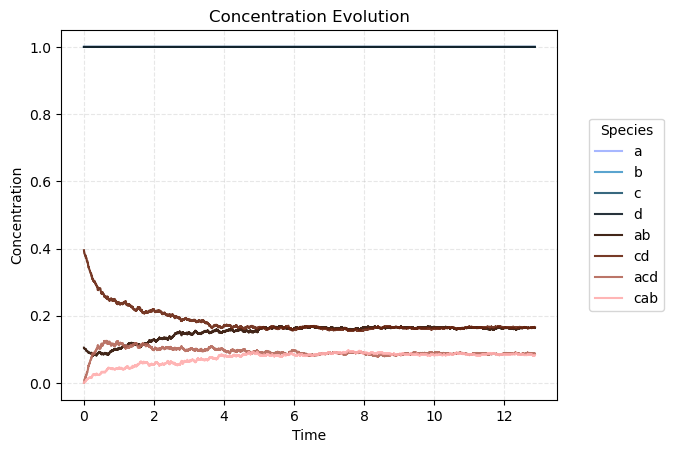

171
329


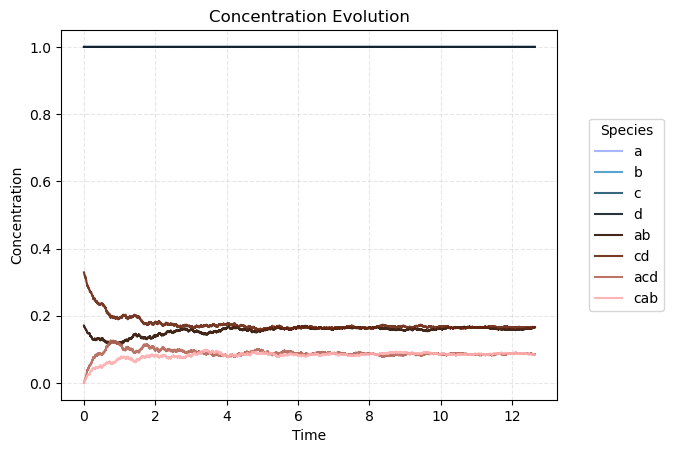

218
282


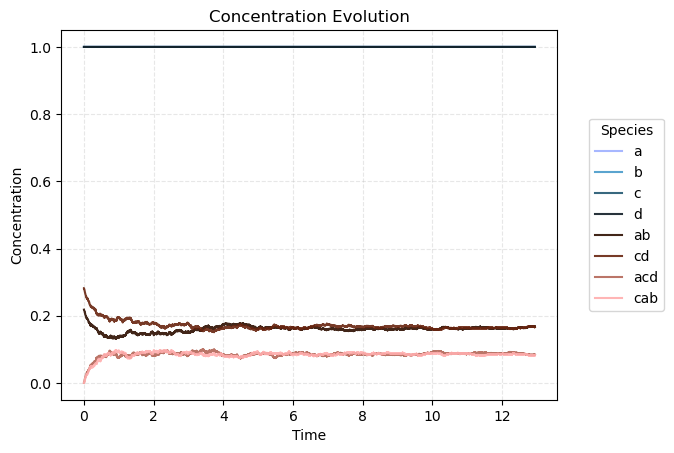

13
487


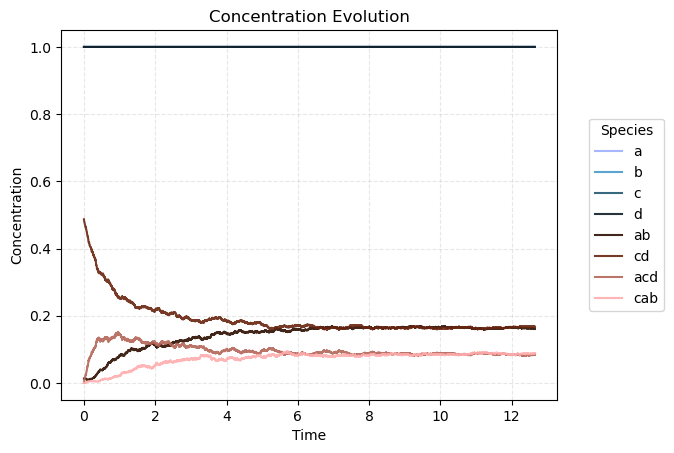

361
139


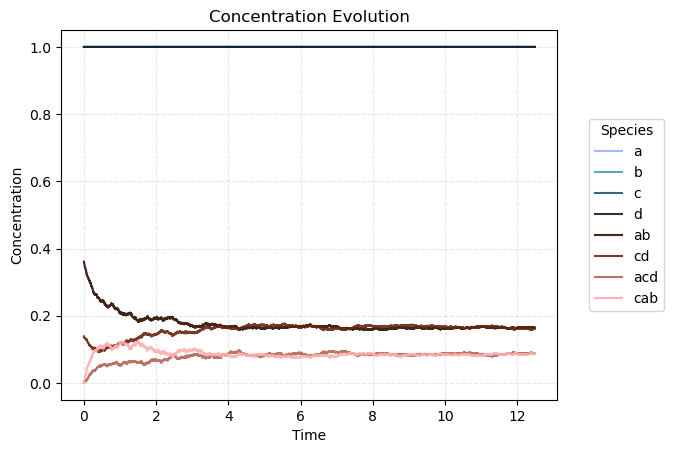

114
886


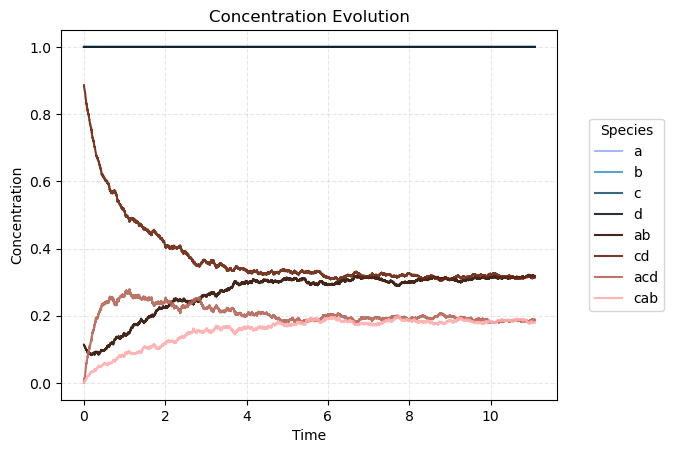

797
203


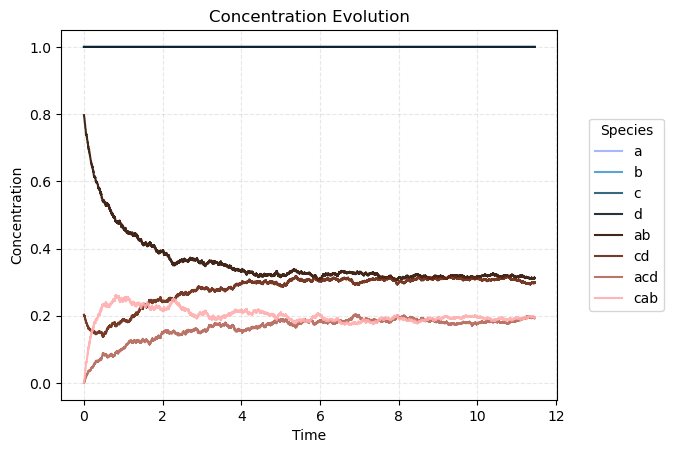

860
140


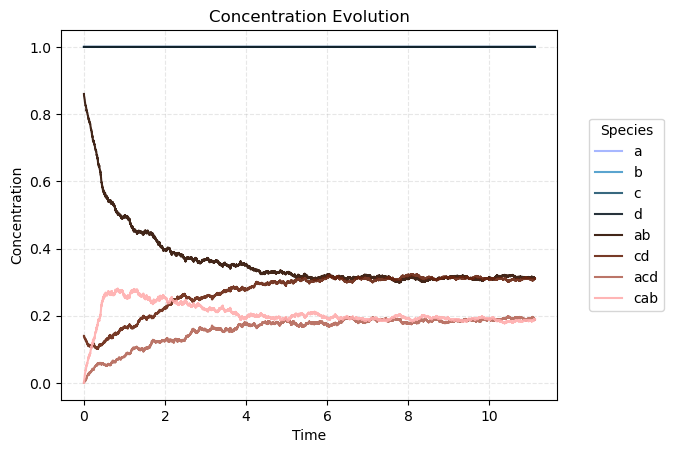

737
263


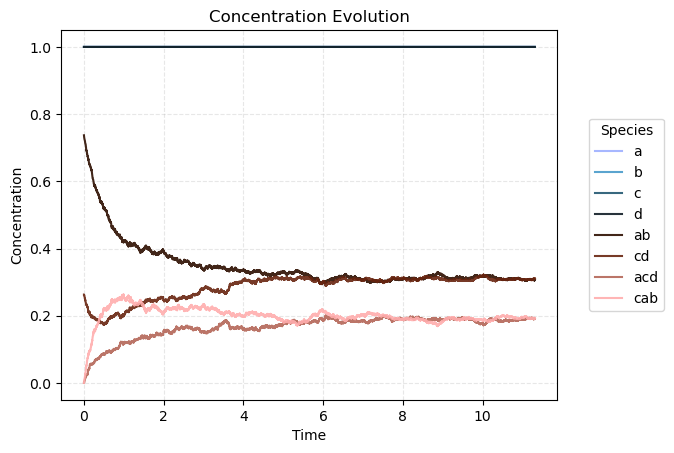

529
471


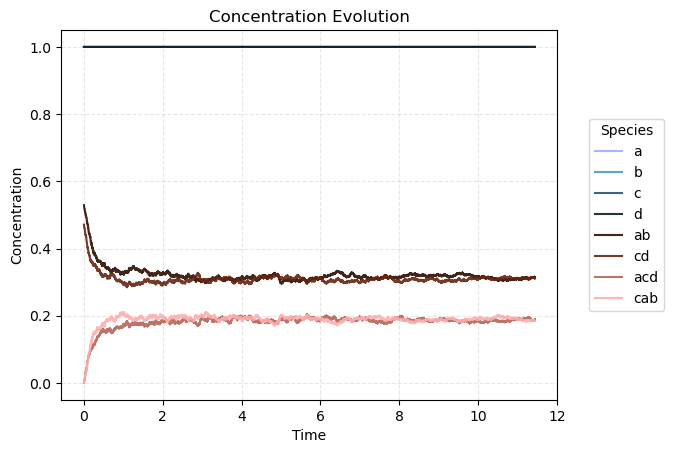

1754
246


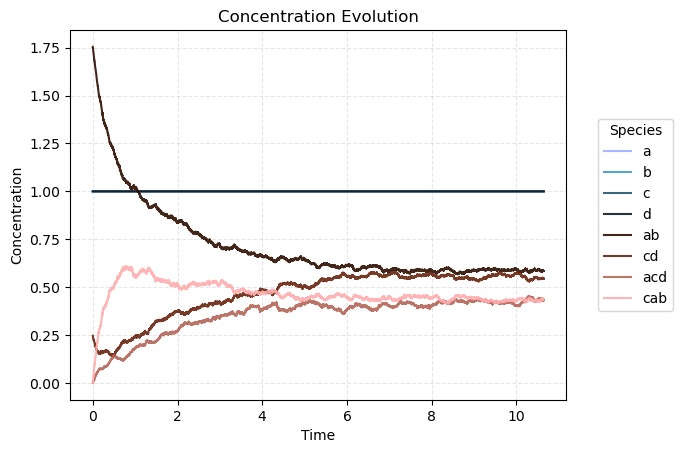

1546
454


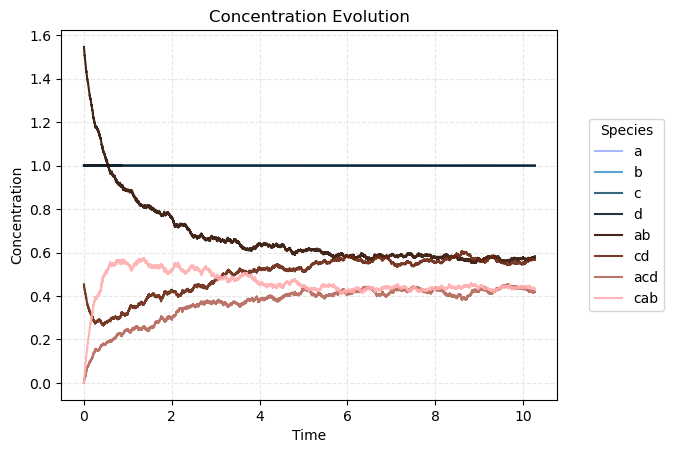

1885
115


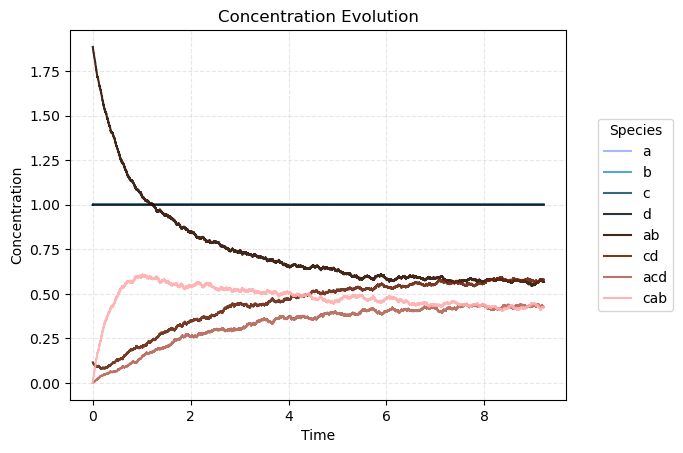

1986
14


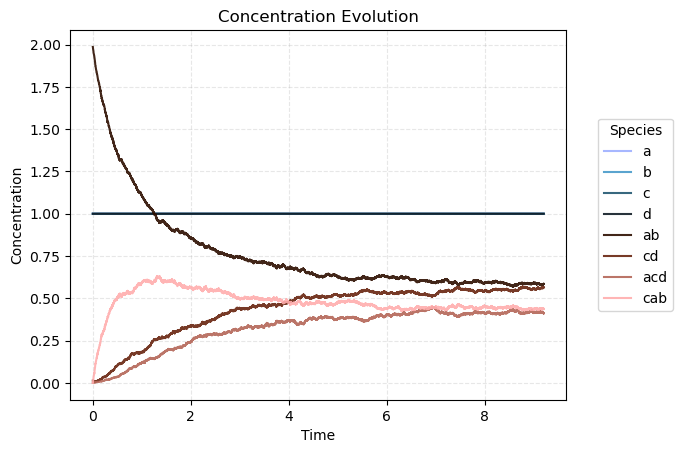

1834
166


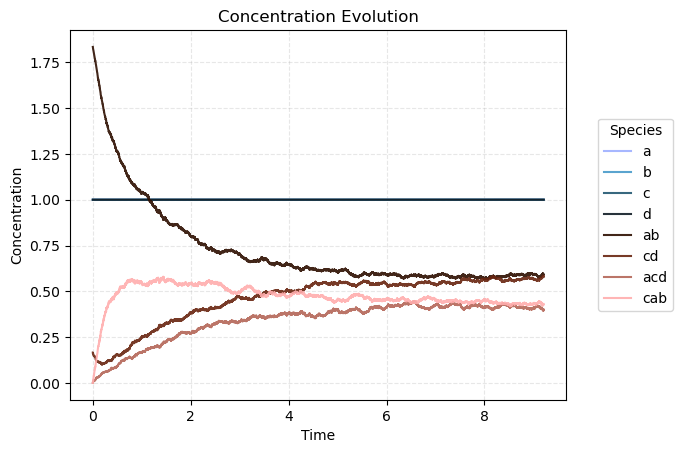

In [12]:
from random import random
n_iterations = 1e5
method = "Protocell" # Gillespie or Deterministic
# Reaction constants:
k = [1]*8 # len(k)= # de reacciones
# Volume:
V = 1000
initial_food = [1000]*4 + [0]*4 # initial molecules number

concentrations = [0.5,1,2]

for i in concentrations:
    total_abundance = i * V
    for j in range(5):
        random_number = random()
        initial_food[4] = round(random_number * total_abundance)
        initial_food[5] = round(total_abundance - (random_number * total_abundance))
        print(initial_food[4])
        print(initial_food[5])
        abundances, times, volumes = chemistry(method, n_iterations, reactions,
                                initial_food, k, V)
        
        plot_concentration(abundances, times, volumes)

## catalizador mínimo

1


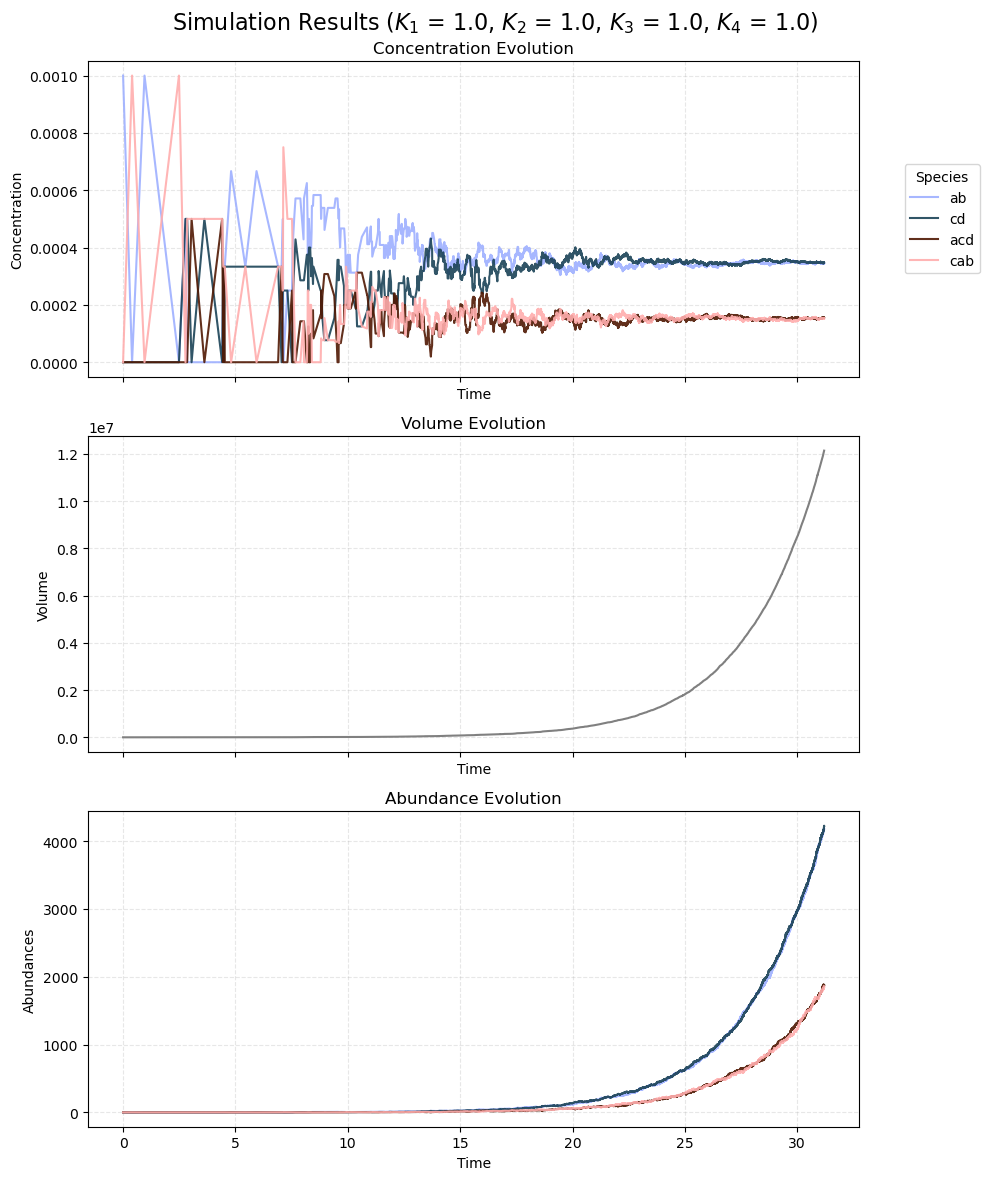

11


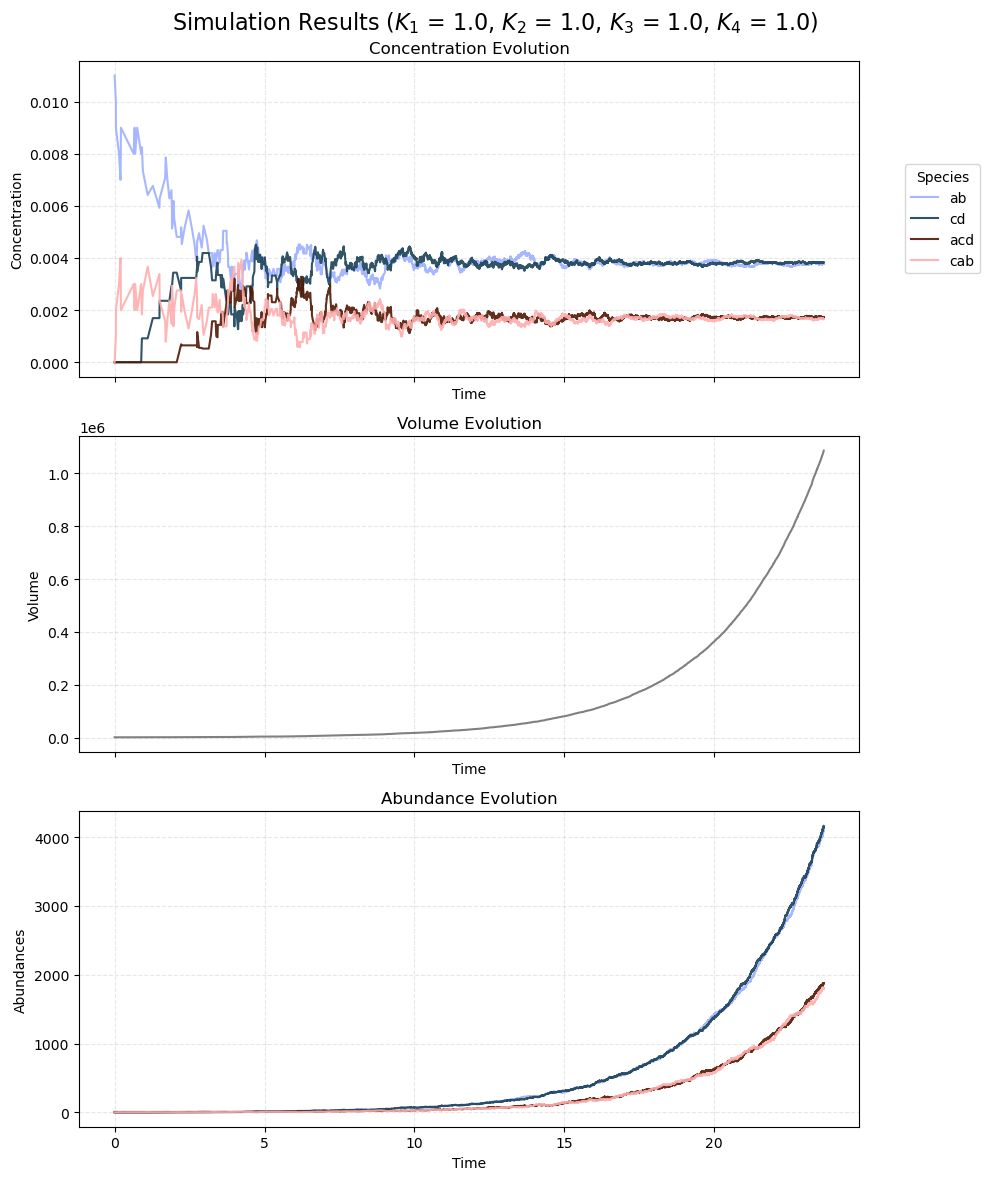

21


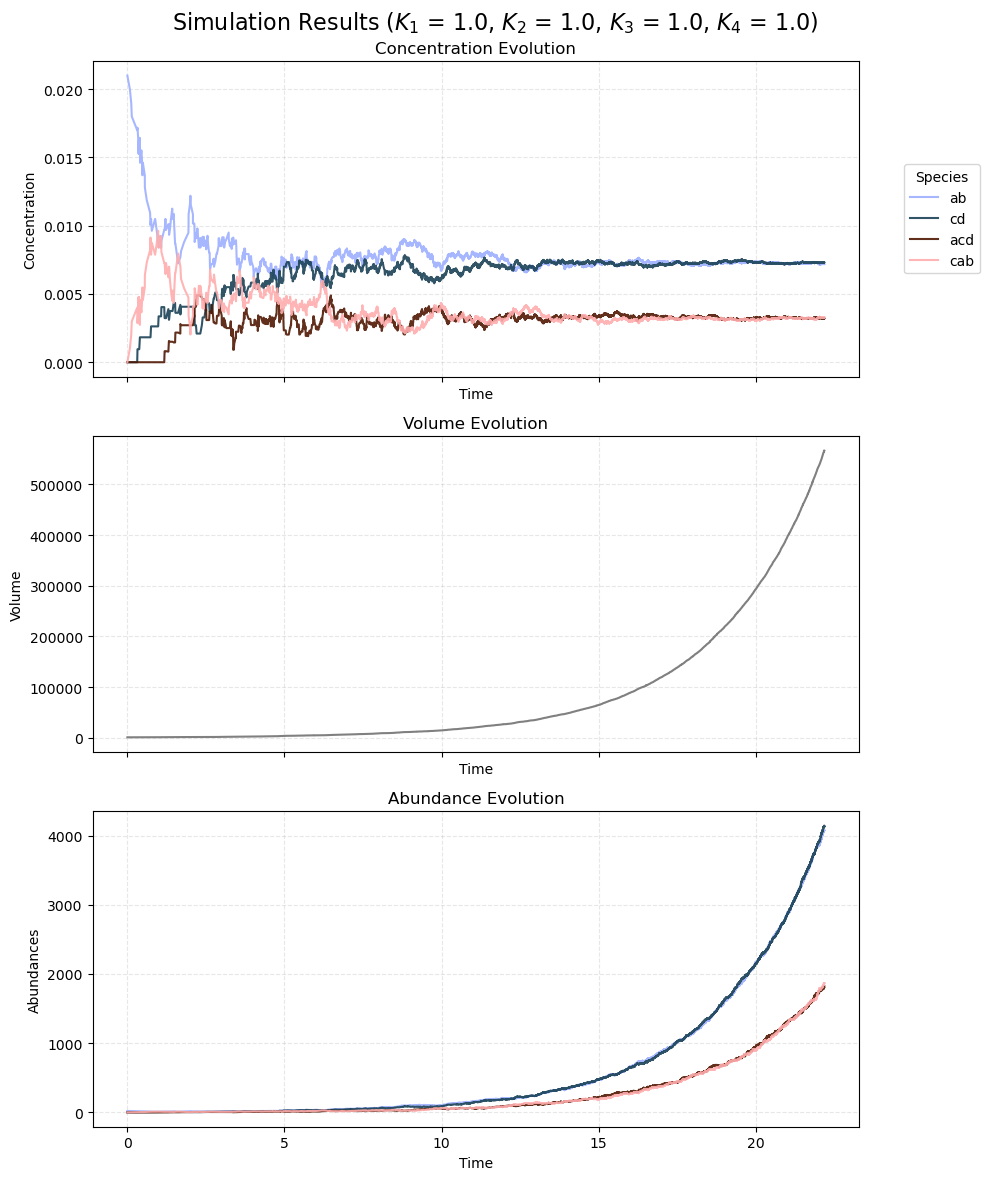

31


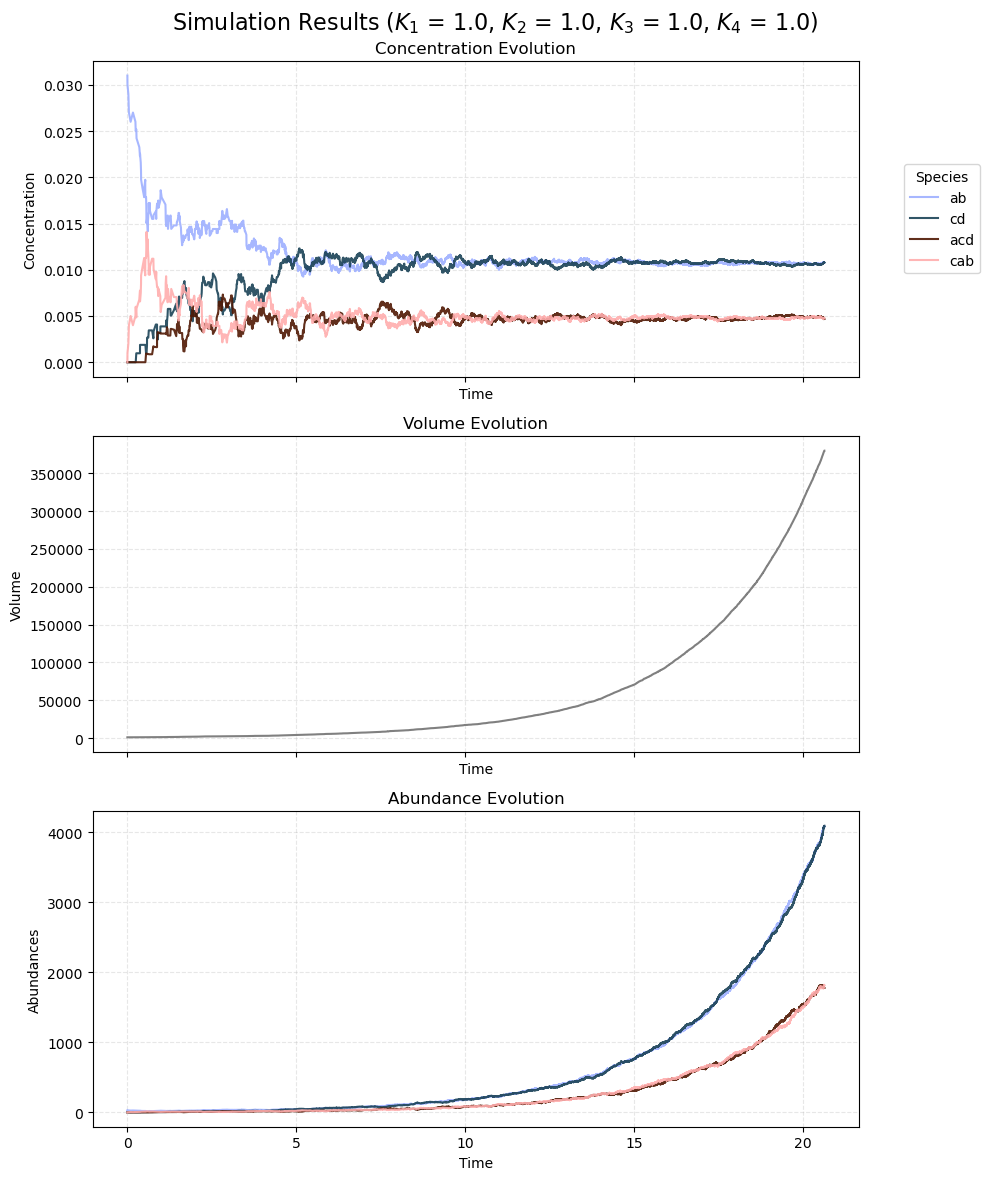

41


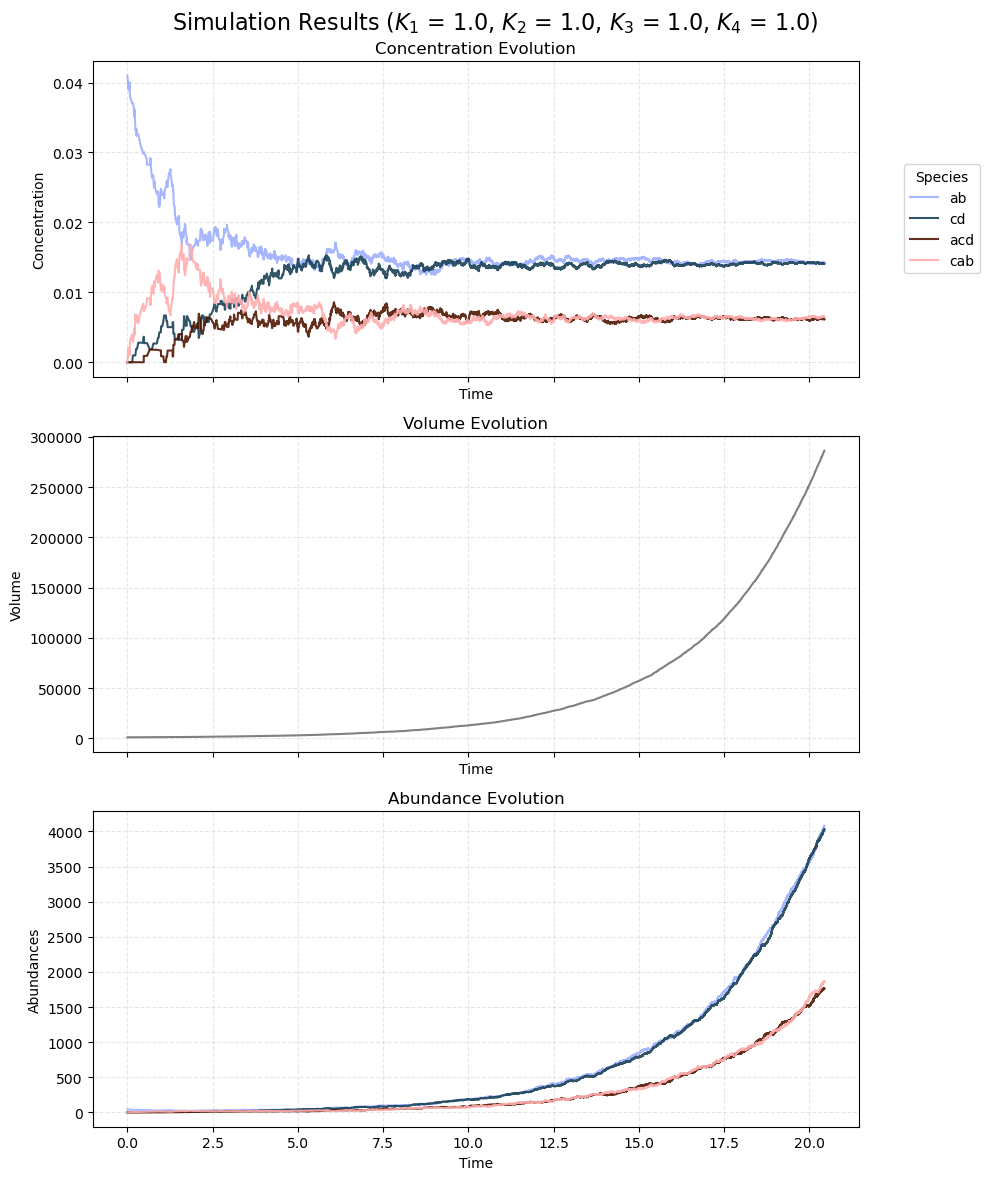

51


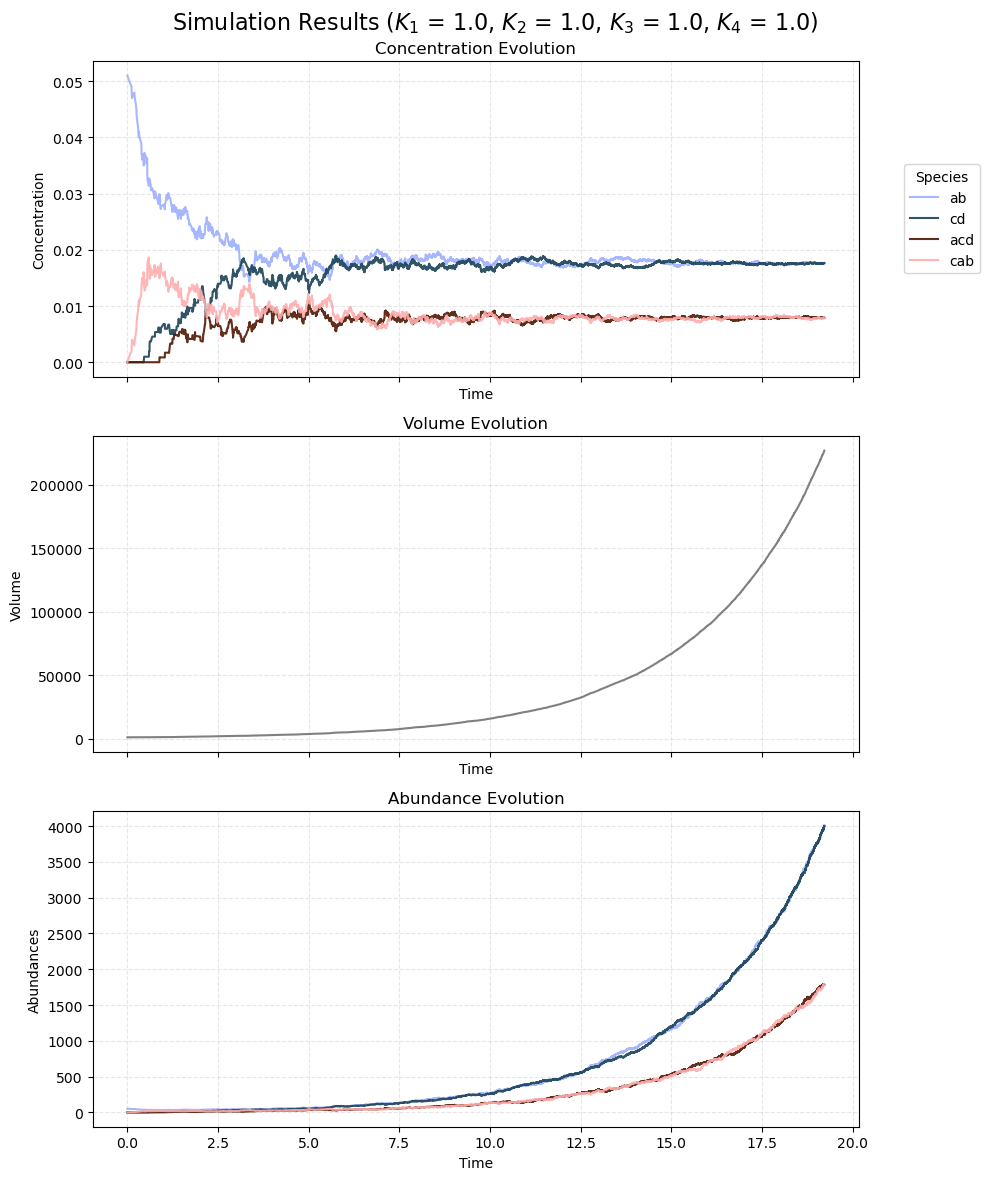

61


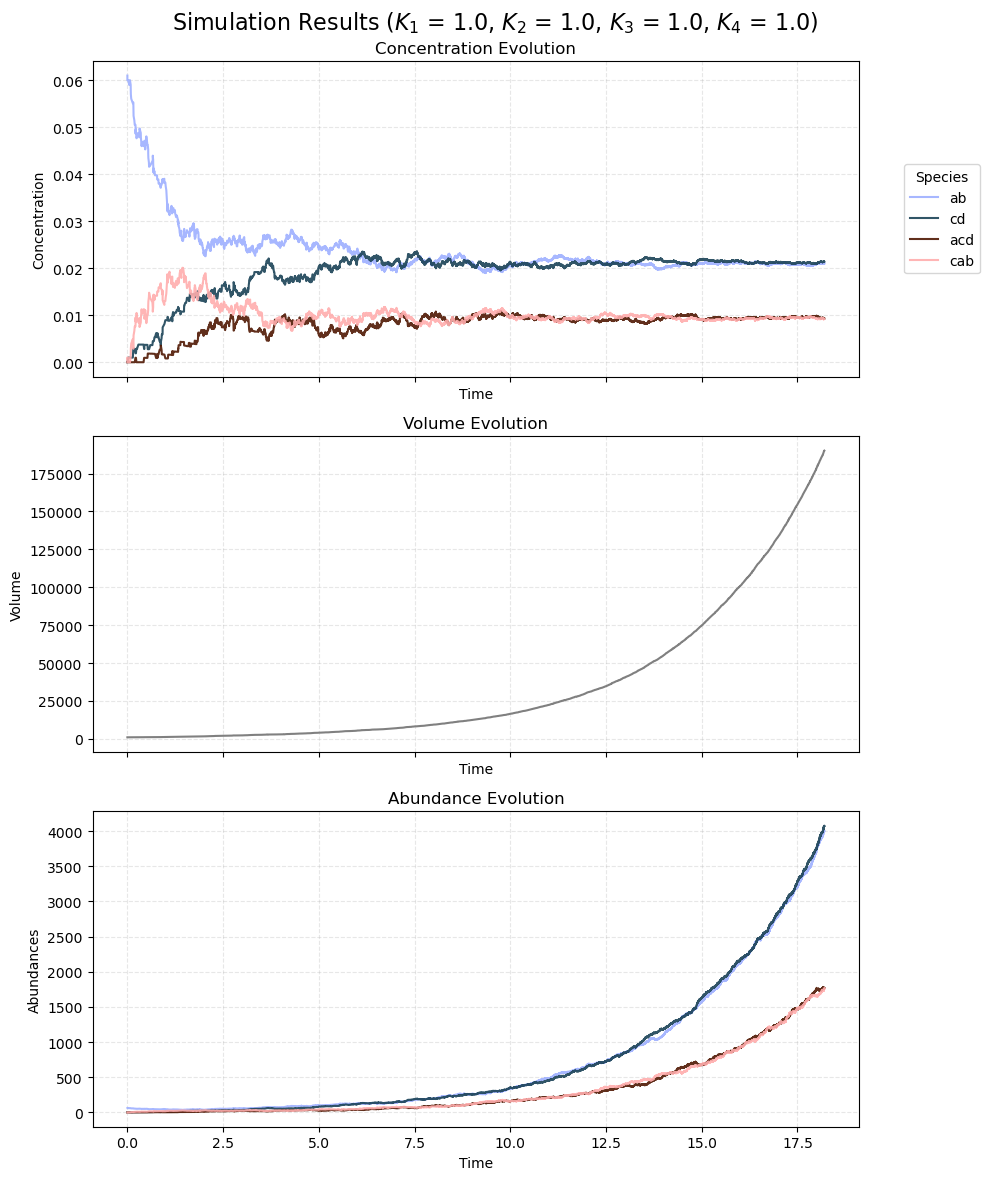

71


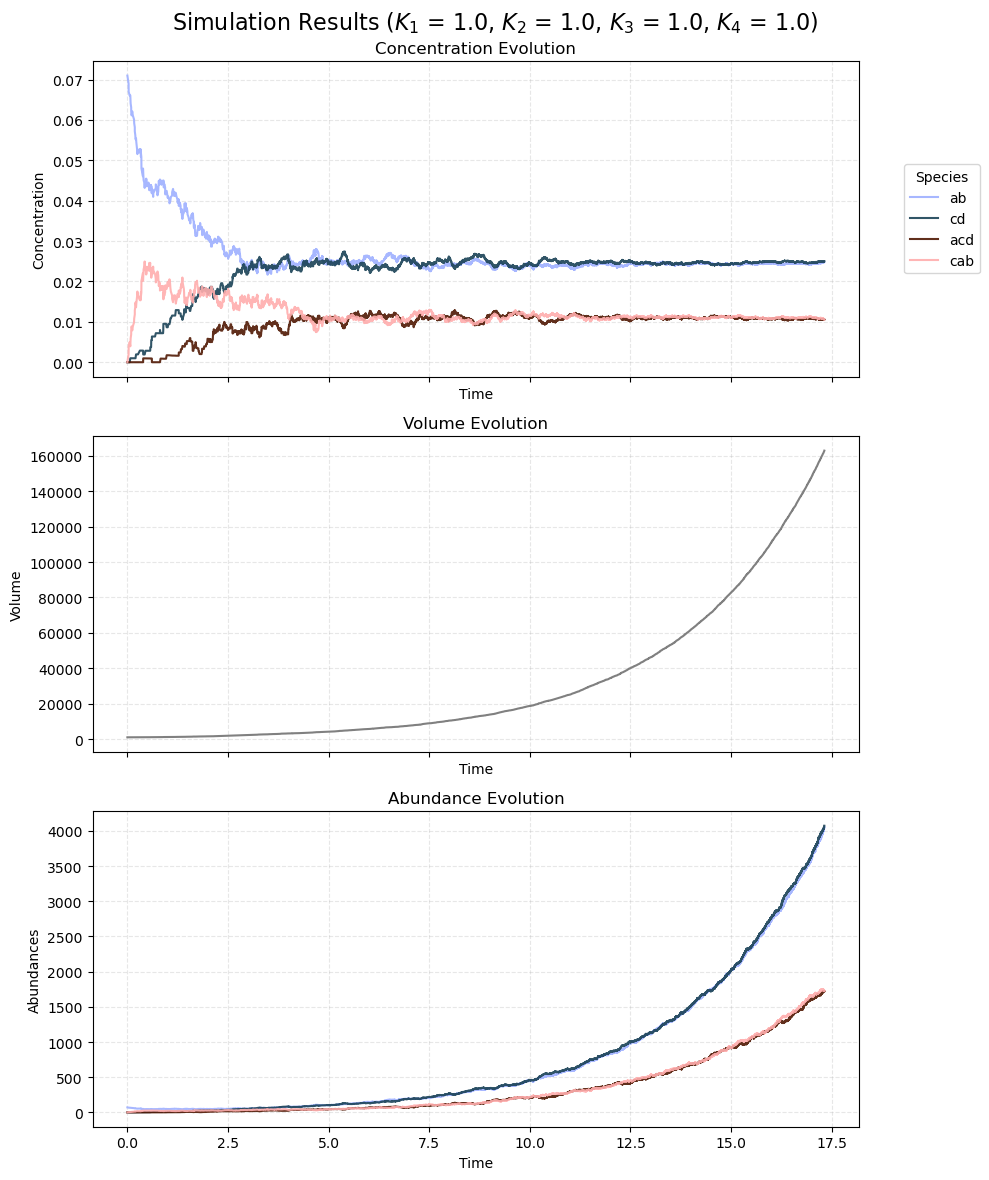

81


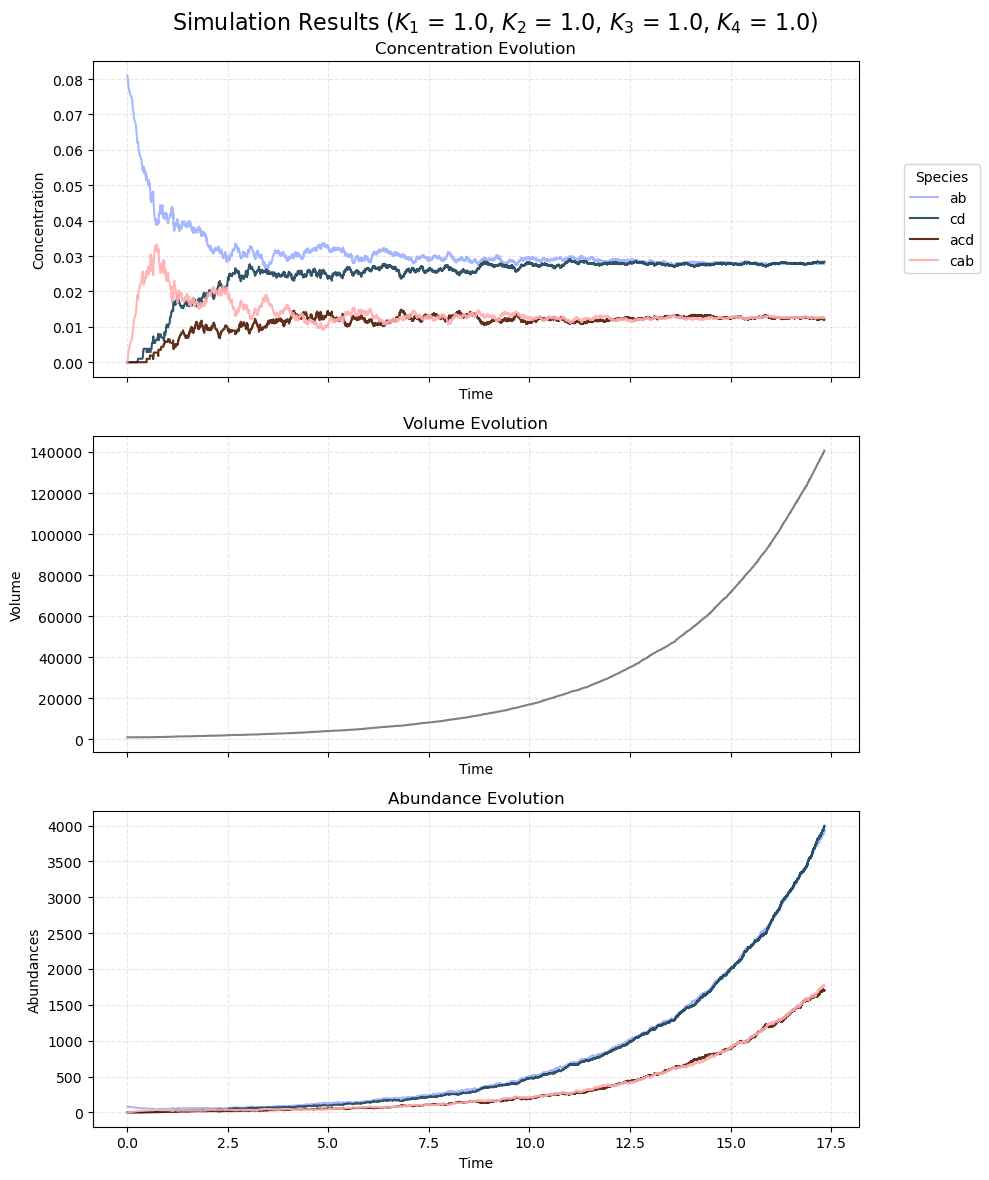

91


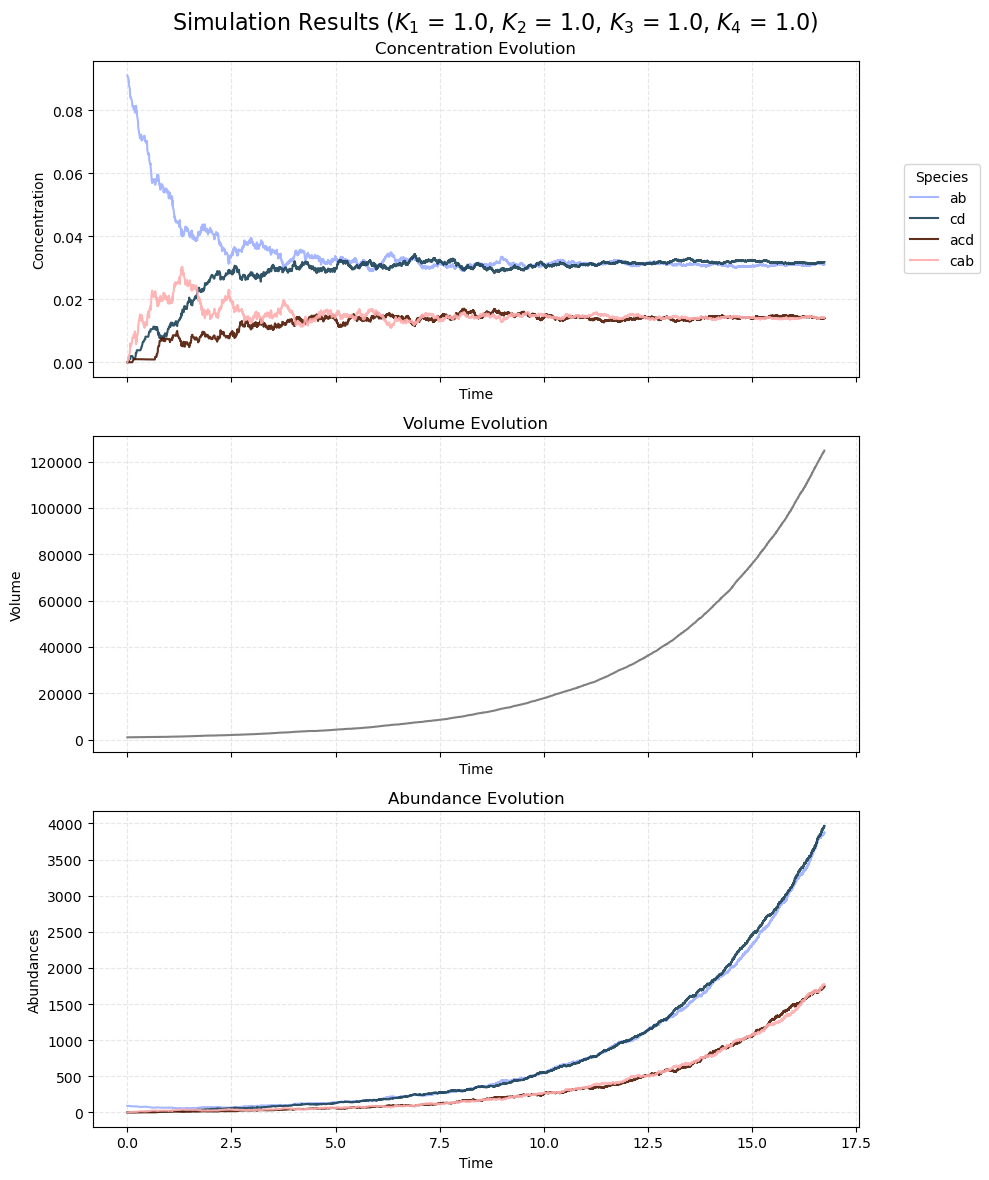

In [11]:
n_iterations = 1e5
method = "Protocell" # Gillespie or Deterministic
# Reaction constants:
k = [1]*8 # len(k)= # de reacciones
# Volume:
V = 1000
initial_food = [1000]*4 + [0]*4 # initial molecules number

catal_abundances = range(1,100,10)

for total_abundance in catal_abundances:
    initial_food[4] = total_abundance
    print(initial_food[4])
    abundances, times, volumes = chemistry(method, n_iterations, reactions,
                            initial_food, k, V)
    
    plot(abundances[:,4:], times, volumes, species[4:])

# figura molona barrido

In [10]:
from random import random
n_iterations = 2e5
method = "Protocell" # Gillespie or Deterministic
# Reaction constants:
k = [1]*8 # len(k)= # de reacciones
# Volume:
V = 1000
initial_food = [1000]*4 + [0]*4 # initial molecules number
concentration = 1
final_concentrations = []
initial_conditions = []

total_abundance = concentration * V
for i in range(11):
    for j in range(4, len(species)):
        initial_food[j] = random()
        
    total_0 = sum(initial_food[4:])
    for j in range(4, len(species)):
        initial_food[j] = (initial_food[j]/total_0)*concentration*V
    
    print(f"Performing simulation for\
          [ab] = {initial_food[4]},\
          [cd] = {initial_food[5]},\
          [acd] = {initial_food[6]},\
              [cab] = {initial_food[7]}")
    
    abundances, times, volumes = chemistry(method, n_iterations, reactions,
                            initial_food, k, V)
    
    concentrations = (abundances.T / volumes).T
    
    initial_conditions.append(initial_food[4:])
    final_concentrations.append(np.mean(concentrations[-500:,4:], axis= 0))
    
initial_conditions = np.array(initial_conditions)
final_concentrations = np.array(final_concentrations)        

Performing simulation for          [ab] = 200.65175947809857,          [cd] = 285.22268312430526,          [acd] = 187.4155906476895,              [cab] = 326.70996674990664
Performing simulation for          [ab] = 390.8617747864471,          [cd] = 65.83869394432156,          [acd] = 398.12220280340927,              [cab] = 145.17732846582214
Performing simulation for          [ab] = 87.1694097243349,          [cd] = 388.43250883537576,          [acd] = 267.6366815427087,              [cab] = 256.76139989758065
Performing simulation for          [ab] = 243.20327477054946,          [cd] = 420.8961052494592,          [acd] = 263.8273233388314,              [cab] = 72.07329664115994
Performing simulation for          [ab] = 274.50462977209224,          [cd] = 223.24188094050038,          [acd] = 387.5311036278958,              [cab] = 114.7223856595117
Performing simulation for          [ab] = 362.3479409851989,          [cd] = 181.30743721451725,          [acd] = 153.48223714914914,   

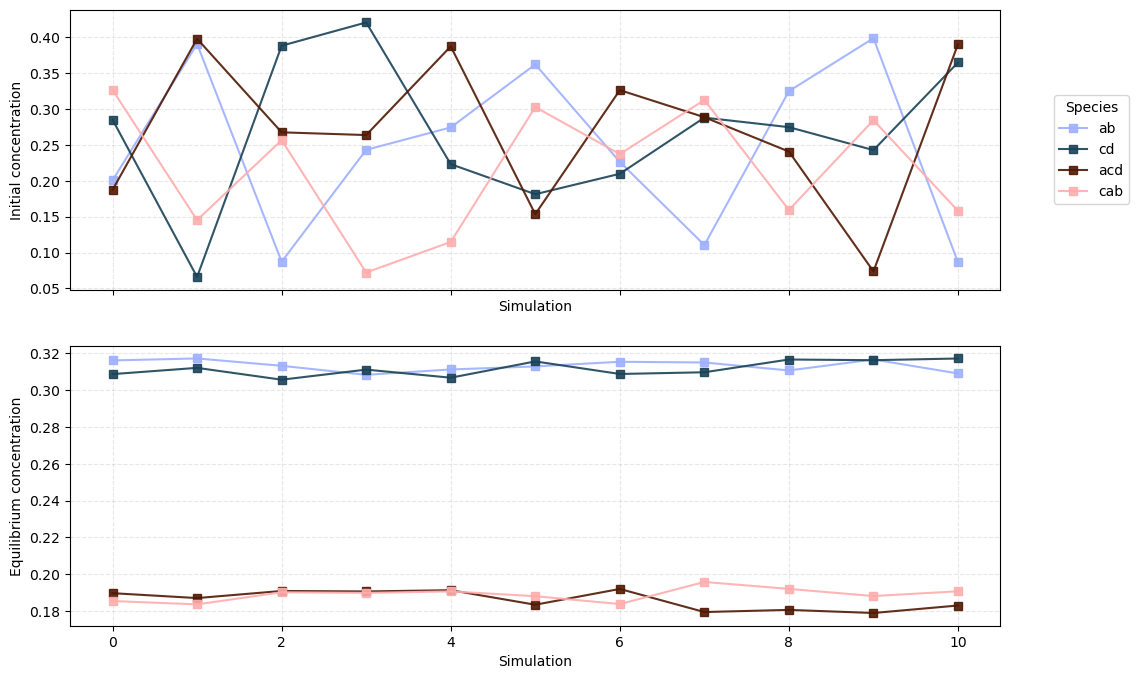

In [14]:
plot_barrido(initial_conditions/V, final_concentrations, species[4:])


# figura cambio de vol con condicion inicial

In [32]:
n_iterations = 1.5e5
method = "Protocell" # Gillespie or Deterministic
# Reaction constants:
k = [1]*8 # len(k)= # de reacciones
# Volume:
V = 1000
initial_food = [1000]*4 + [0]*4 # initial molecules number
final_volume = []
initial_ab = np.linspace(1000,7000,6)

for ab in initial_ab:
    initial_food[4] = ab
    print(f"Performing simulation for [ab]={ab}")
    abundances, times, volumes = chemistry(method, n_iterations, reactions,
                            initial_food, k, V)
    print(f"Simulation ended. Final volume = {volumes[-1]}")
    
    try:
        print(f"Volume at t= 10 = {volumes[times>10][0]}")
        final_volume.append(volumes[times>10][0])
    except IndexError:
        final_volume.append(volumes[-1])
    

Performing simulation for [ab]=1000.0
Simulation ended. Final volume = 7198.0
Volume at t= 10 = 6065.0
Performing simulation for [ab]=2200.0
Simulation ended. Final volume = 2346.363636363636
Performing simulation for [ab]=3400.0
Simulation ended. Final volume = 1476.1764705882354
Performing simulation for [ab]=4600.0
Criterion for stop was # of iterations
Simulation ended. Final volume = 923.913043478261
Volume at t= 10 = 1032.1739130434783
Performing simulation for [ab]=5800.0
Criterion for stop was # of iterations
Simulation ended. Final volume = 547.5862068965517
Volume at t= 10 = 738.6206896551724
Performing simulation for [ab]=7000.0
Criterion for stop was # of iterations
Simulation ended. Final volume = 435.0
Volume at t= 10 = 577.8571428571429


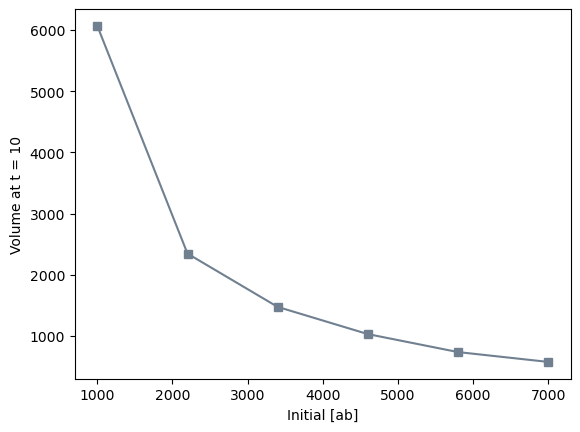

In [35]:
plot_volume(final_volume, initial_ab)

# cambio de volumen con K

In [91]:
n_iterations = 5e5
method = "Protocell" # Gillespie or Deterministic
# Reaction constants:
k = [1]*8 # len(k)= # de reacciones
# Volume:
V = 1000
initial_food = [1000]*4 + [500]*2 + [0]*2 # initial molecules number
final_volume = []
k_change = np.logspace(-3,4,8)
simulations_k = {}

for k_i in k_change:
    k[0] = k_i
    print(f"Performing simulation for k = {k_i}")
    abundances, times, volumes = chemistry(method, n_iterations, f,
                            initial_food, k, V)
    print(f"Simulation ended. Final volume = {volumes[-1]}")
    simulations_k[k_i] = (abundances, times, volumes)

Performing simulation for k = 0.001
Simulation ended. Final volume = 909.0
Performing simulation for k = 0.01
Simulation ended. Final volume = 895.0
Performing simulation for k = 0.1
Simulation ended. Final volume = 1908.0
Performing simulation for k = 1.0
Simulation ended. Final volume = 6856.0
Performing simulation for k = 10.0
Simulation ended. Final volume = 11155.0
Performing simulation for k = 100.0
Simulation ended. Final volume = 12082.0
Performing simulation for k = 1000.0
Simulation ended. Final volume = 12264.0
Performing simulation for k = 10000.0
Simulation ended. Final volume = 12417.0


In [96]:
with open("simulacion_barrido_k1.txt", "ab") as file:
    pickle.dump(simulations_k, file)

In [93]:
fit = get_alpha_global(simulations_k)
print(fit.to_string(index=False, float_format="%.4f"))

 Initial [AB]  Alpha  Scaling Const. (A)    R^2
       0.0010 0.0000            858.3199 0.1078
       0.0100 0.0000            884.9649 0.0809
       0.1000 0.0123            831.4480 0.9918
       1.0000 0.1773            907.0835 0.9996
      10.0000 0.4391            916.7888 0.9999
     100.0000 0.5020           1099.3846 0.9998
    1000.0000 0.5226           1038.4913 0.9999
   10000.0000 0.5250           1083.3958 0.9999


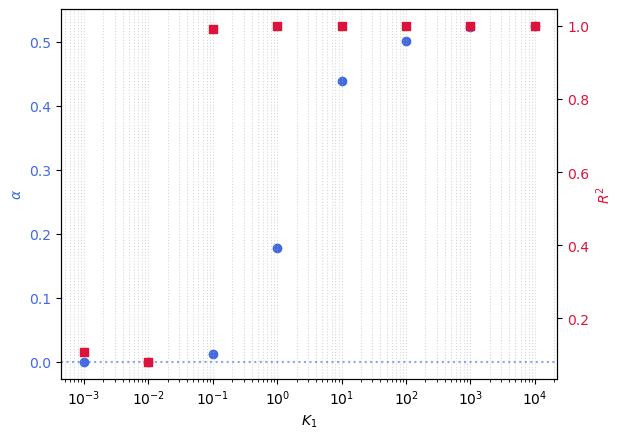

In [ ]:
fig, ax1 = plt.subplots()

ax1.set_xlabel(r'$K_1$') 
ax1.set_ylabel(r'$\alpha$', color="royalblue")
ax1.scatter(fit['Initial [AB]'], fit['Alpha'], 
            color="royalblue", marker='o')

ax1.tick_params(axis='y', labelcolor="royalblue")
ax1.grid(True, linestyle=':', alpha=0.5, which='both', axis='x')
ax1.axhline(y= 0, color= "royalblue", alpha= 0.6, linestyle=":")
ax1.set_xscale("log")
ax2 = ax1.twinx()  

ax2.set_ylabel(r'$R^2$', color="crimson")  
ax2.scatter(fit['Initial [AB]'], fit['R^2'], 
            color="crimson", marker='s')
ax2.set_xscale("log")
ax2.tick_params(axis='y', labelcolor="crimson")

In [18]:
with open("simulacion_barrido_k1.txt", "rb") as file:
    simulations_k = pickle.load(file)

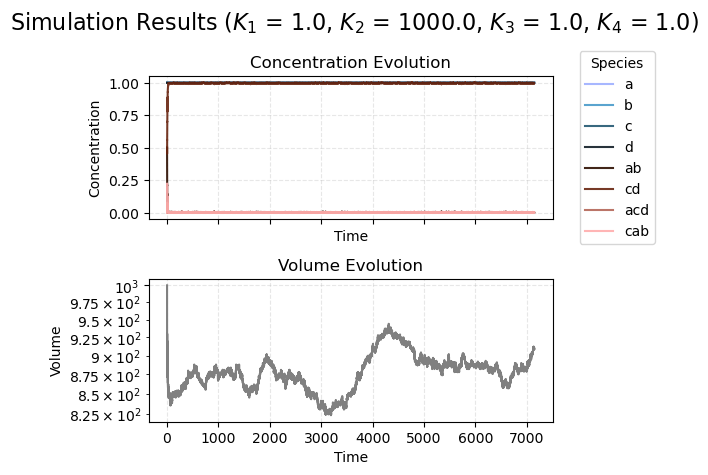

Regression completed. Fitted Scaling Constant A: 858.322
Fitted exponential rate m (alpha): 0.000
Coefficient of Determination (R^2): 0.1078


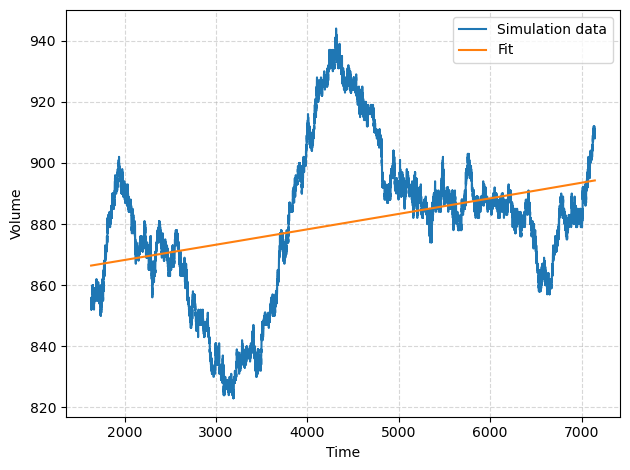

Plot generated successfully.


In [28]:
abundances, times, volumes = simulations_k[0.001]
plot(abundances, times, volumes, species)
plot_ajuste(volumes[round(len(volumes)/3):], times[round(len(volumes)/3):])

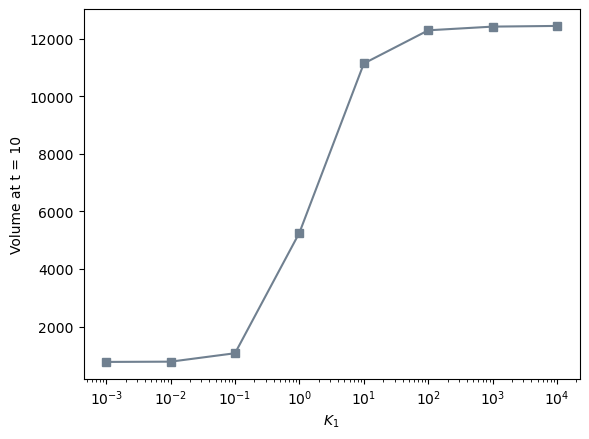

In [58]:
plot_volume_vs_k(final_volume, k_change, k, 0)

In [ ]:
n_iterations = 5e5
method = "Protocell" # Gillespie or Deterministic
# Reaction constants:
k = [1]*8 # len(k)= # de reacciones
# Volume:
V = 1000
initial_food = [1000]*4 + [500]*2 + [0]*2 # initial molecules number
final_volume = []
k_change = np.logspace(-3,4,8)
simulations_k2 = {}

for k_i in k_change:
    k[2] = k_i
    print(f"Performing simulation for k = {k_i}")
    abundances, times, volumes = chemistry(method, n_iterations, f,
                            initial_food, k, V)
    print(f"Simulation ended. Final volume = {volumes[-1]}")
    simulations_k2[k_i] = (abundances, times, volumes)


Performing simulation for k = 0.001
Criterion for stop was # of iterations
Simulation ended. Final volume = 1049.0
Performing simulation for k = 0.01
Simulation ended. Final volume = 1552.0
Performing simulation for k = 0.1
Simulation ended. Final volume = 2195.0
Performing simulation for k = 1.0
Simulation ended. Final volume = 6858.0
Performing simulation for k = 10.0
Simulation ended. Final volume = 10726.0
Performing simulation for k = 100.0
Simulation ended. Final volume = 11582.0
Performing simulation for k = 1000.0
Simulation ended. Final volume = 11779.0
Performing simulation for k = 10000.0
Simulation ended. Final volume = 11839.0


In [99]:
with open("simulacion_barrido_k2.txt", "ab") as file:
    pickle.dump(simulations_k2, file)

In [11]:
with open("simulacion_barrido_k2.txt", "rb") as file:
    simulations_k2 = pickle.load(file)

In [17]:
fit = get_alpha_global(simulations_k2)
print(fit.to_string(index=False, float_format="%.4f"))

 Initial [AB]  Alpha  Scaling Const. (A)    R^2
       0.0010 0.0002            942.4355 0.9688
       0.0100 0.0029            974.0330 0.9908
       0.1000 0.0271           1002.8551 0.9974
       1.0000 0.1834            834.9446 0.9997
      10.0000 0.3545            906.7202 0.9999
     100.0000 0.3985            964.1442 0.9999
    1000.0000 0.4009           1031.2532 0.9999
   10000.0000 0.3958           1082.4758 0.9996


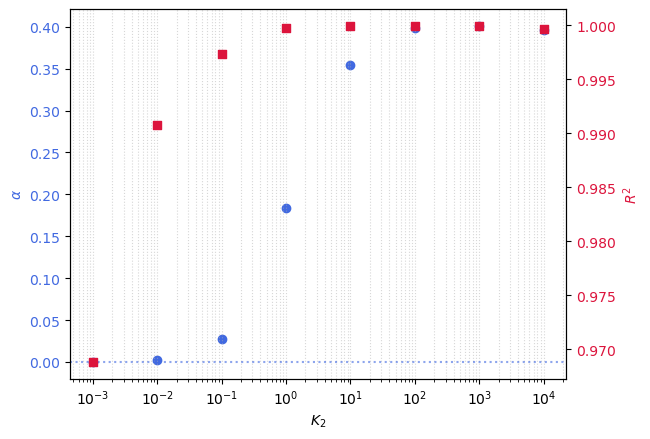

In [18]:
fig, ax1 = plt.subplots()

ax1.set_xlabel(r'$K_2$') 
ax1.set_ylabel(r'$\alpha$', color="royalblue")
ax1.scatter(fit['Initial [AB]'], fit['Alpha'], 
            color="royalblue", marker='o')

ax1.tick_params(axis='y', labelcolor="royalblue")
ax1.grid(True, linestyle=':', alpha=0.5, which='both', axis='x')
ax1.axhline(y= 0, color= "royalblue", alpha= 0.6, linestyle=":")
ax1.set_xscale("log")
ax2 = ax1.twinx()  

ax2.set_ylabel(r'$R^2$', color="crimson")  
ax2.scatter(fit['Initial [AB]'], fit['R^2'], 
            color="crimson", marker='s')
ax2.set_xscale("log")
ax2.tick_params(axis='y', labelcolor="crimson")

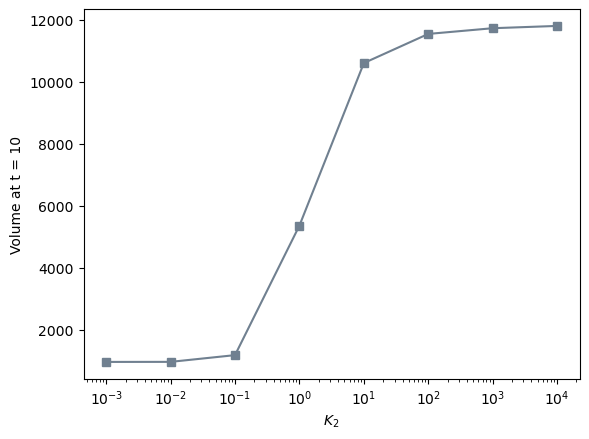

In [60]:
plot_volume_vs_k(final_volume, k_change, k, 2)

In [10]:
abundances, times, volumes = simulations_k2[0.001]

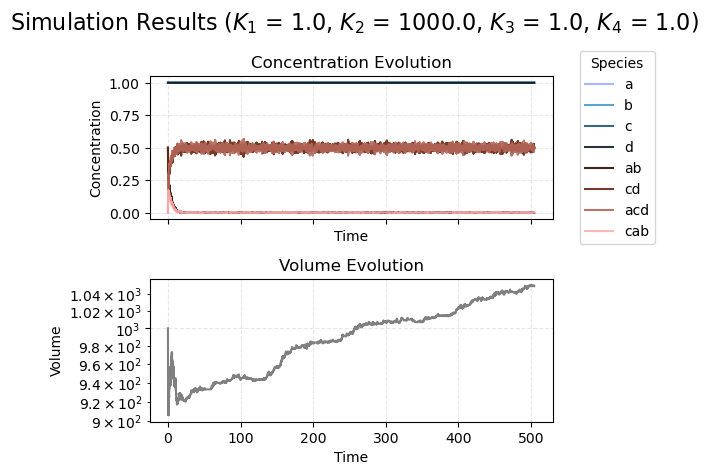

Regression completed. Fitted Scaling Constant A: 942.435
Fitted exponential rate m (alpha): 0.000
Coefficient of Determination (R^2): 0.9688


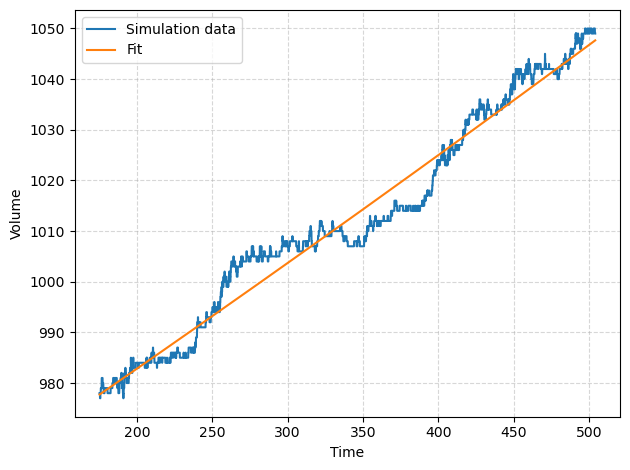

Plot generated successfully.


In [17]:
k= [1,1,0.001,1,1,1,1,1]
plot(abundances, times, volumes, species)
plot_ajuste(volumes[round(len(volumes)/3):], times[round(len(volumes)/3):])


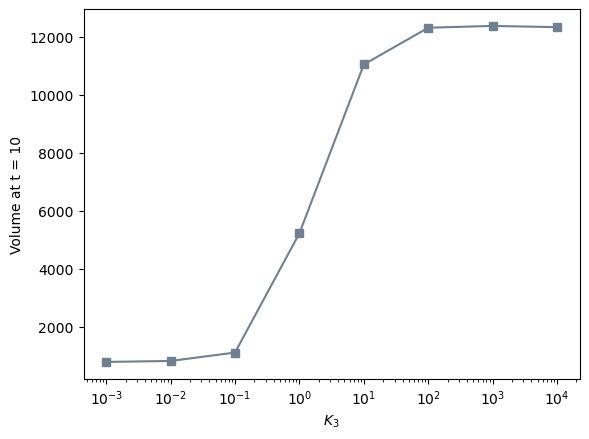

In [12]:
plot_volume_vs_k(final_volume, k_change, k, 4)